In [1]:
# Setup
import sys
import numpy as np
import tensorflow as tf
import Utils.PokemonUtils as pkmnUtils
from matplotlib import pyplot as plt
import importlib

utils = pkmnUtils.PokemonUtils(rel_loc="")
utils.localLoadAllGifs("Data/SplitsV2.npz")
x_train, x_val, x_test, y_train, y_val, y_test = utils.getSplits()

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


x_train: (6010, 128, 128, 4)
x_val:   (1510, 128, 128, 4)
x_test:  (1880, 128, 128, 4)
y_train: (6010,)
y_val:   (1510,)
y_test:  (1880,)


In [154]:
import Utils.PokemonPlot as pp
importlib.reload(pp)  # update import for changes

<module 'Utils.PokemonPlot' from '/home/zack/pokemon-learning/Utils/PokemonPlot.py'>

In [160]:
import Utils.PokemonModelUtils as pmu
importlib.reload(pmu)  # update import for changes

<module 'Utils.PokemonModelUtils' from '/home/zack/pokemon-learning/Utils/PokemonModelUtils.py'>

In [ ]:
# Run on PokemonUtils update
import Utils.PokemonUtils as pkmnUtils
importlib.reload(pkmnUtils)  # update import if PokemonUtils.py changes
utils = pkmnUtils.PokemonUtils(utils=utils)

In [3]:
x_train_m = x_train.astype('float32') 
x_val_m = x_val.astype('float32') 
x_test_m = x_test.astype('float32')
y_train_m = y_train
y_val_m = y_val
y_test_m = y_test

# Images (range 0-1 necessary for imshow)
x_train_i = (x_train_m) / 255
x_val_i   = (x_val_m)   / 255
x_test_i  = (x_test_m)  / 255

# Model
x_mean = np.mean(x_train_m)
x_train_m = (x_train_m - x_mean) / 255
x_val_m   = (x_val_m - x_mean)   / 255
x_test_m  = (x_test_m - x_mean)  / 255

# Small (1 frame per pokemon)
x_train_s = x_train_m[::10]
x_val_s   = x_val_m[::10]
x_test_s  = x_test_m[::10]
y_train_s = y_train_m[::10]
y_val_s   = y_val_m[::10]
y_test_s  = y_test_m[::10]

# Downsampled (5 frames per pokemon, 64x64)
x_train_d = x_train_m[::2,::2,::2,:]
x_val_d   = x_val_m[::2,::2,::2,:]
x_test_d  = x_test_m[::2,::2,::2,:]
y_train_d = y_train_m[::2]
y_val_d   = y_val_m[::2]
y_test_d  = y_test_m[::2]

print("Data normalization:")
print("mean:", x_mean)
print("max: ", np.max(x_train_m))
print("min: ", np.min(x_train_m))
print("Data shapes:")
print("x_train_m:", x_train_m.shape)
print("x_val_m:  ", x_val_m.shape)
print("x_test_m: ", x_test_m.shape)
print("y_train_m:", y_train_m.shape)
print("y_val_m:  ", y_val_m.shape)
print("y_test_m: ", y_test_m.shape)
print("x_train_s:", x_train_s.shape)
print("x_val_s:  ", x_val_s.shape)
print("x_test_s: ", x_test_s.shape)
print("y_train_s:", y_train_s.shape)
print("y_val_s:  ", y_val_s.shape)
print("y_test_s: ", y_test_s.shape)
print("x_train_d:", x_train_d.shape)
print("x_val_d:  ", x_val_d.shape)
print("x_test_d: ", x_test_d.shape)
print("y_train_d:", y_train_d.shape)
print("y_val_d:  ", y_val_d.shape)
print("y_test_d: ", y_test_d.shape)

Data normalization:
mean: 26.632238
max:  0.89555985
min:  -0.10444015
Data shapes:
x_train_m: (6010, 128, 128, 4)
x_val_m:   (1510, 128, 128, 4)
x_test_m:  (1880, 128, 128, 4)
y_train_m: (6010,)
y_val_m:   (1510,)
y_test_m:  (1880,)
x_train_s: (601, 128, 128, 4)
x_val_s:   (151, 128, 128, 4)
x_test_s:  (188, 128, 128, 4)
y_train_s: (601,)
y_val_s:   (151,)
y_test_s:  (188,)
x_train_d: (3005, 64, 64, 4)
x_val_d:   (755, 64, 64, 4)
x_test_d:  (940, 64, 64, 4)
y_train_d: (3005,)
y_val_d:   (755,)
y_test_d:  (940,)


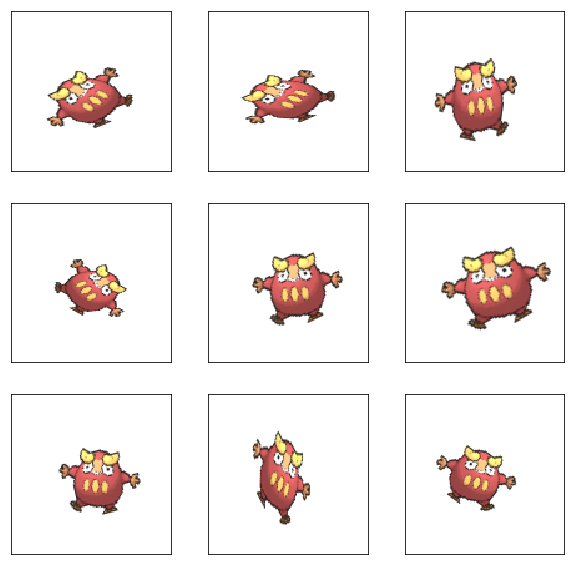

In [29]:
# Functions / objects necessary to train a model
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import skimage.color as color

def oneHot(y, cols=None):
    if (cols < 1):
        cols = np.max(y)
    n = y.shape[0]
    z = np.zeros((n, cols))
    z[np.arange(n), (y-1)] = 1
    return z


data_aug = ImageDataGenerator(
    rotation_range=50,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

image = x_train_i[0,:,:,:]
image = image.reshape((1,) + image.shape)

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,3)

i = 0
for batch in data_aug.flow(image, batch_size=1):
    ax = plt.subplot(gs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(batch[0])
    i += 1
    if i >= 9:
        break

In [178]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import regularizers
from keras.callbacks import ModelCheckpoint

use_baseline = False
model = None

def getInitialModel(use_baseline, reg=0, drop=0.5, downsample=1, kernel=5):
    if use_baseline:
        model = Sequential([
                Conv2D(32, (5, 5), input_shape=(128,128,4)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Conv2D(64, (5, 5)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Flatten(),

                Dense(64),
                Activation("relu"),
                Dense(18),
                Activation("softmax")
            ])
    else:
        print("Model params: drop =", drop, ", reg =", reg)
        model = Sequential([
                Conv2D(32, (kernel, kernel), input_shape=(128//downsample,128//downsample,4), padding='same', kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Conv2D(64, (kernel, kernel), padding='same', kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Flatten(),

                Dense(64, kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                Dropout(drop),
                Dense(18, kernel_regularizer=regularizers.l2(reg)),
                Activation("softmax")
            ])
    return model

In [123]:
model = getInitialModel(False, reg=.001, drop=.1)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [124]:
# Training
# Make SURE filepaths are correct!
n = "7"
print("Training model #"+n) + # CHECK ME!

filepath = "./Models/neuralmon_model_"+n+".hdf5"  
batch_size = 64
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(
    data_aug.flow(x_train_m, oneHot(y_train_m, 18), batch_size=batch_size),
    epochs=20,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=(x_val_m, oneHot(y_val_m, 18)),
)
model.save("./Models/neuralmon_model_"+n+"_final.hdf5")  

Epoch 1/20
94/94 [==============================] - 194s 2s/step - loss: 2.8998 - acc: 0.1386 - val_loss: 2.8063 - val_acc: 0.1344

Epoch 00001: val_acc improved from -inf to 0.13444, saving model to ./Models/neuralmon_model_7.hdf5
Epoch 2/20
94/94 [==============================] - 188s 2s/step - loss: 2.6503 - acc: 0.1907 - val_loss: 2.8438 - val_acc: 0.1437

Epoch 00002: val_acc improved from 0.13444 to 0.14371, saving model to ./Models/neuralmon_model_7.hdf5
Epoch 3/20
94/94 [==============================] - 187s 2s/step - loss: 2.5359 - acc: 0.2166 - val_loss: 2.7469 - val_acc: 0.1841

Epoch 00003: val_acc improved from 0.14371 to 0.18411, saving model to ./Models/neuralmon_model_7.hdf5
Epoch 4/20
94/94 [==============================] - 189s 2s/step - loss: 2.4608 - acc: 0.2484 - val_loss: 2.6638 - val_acc: 0.2291

Epoch 00004: val_acc improved from 0.18411 to 0.22914, saving model to ./Models/neuralmon_model_7.hdf5
Epoch 5/20
94/94 [==============================] - 190s 2s/ste

In [46]:
# Run to resume training

# history2 = model.fit_generator(
#     data_aug.flow(x_train_m, oneHot(y_train_m, 18), batch_size=batch_size),
#     epochs=20,
#     verbose=1,
#     validation_data=(x_val_m, oneHot(y_val_m, 18)),
#     steps_per_epoch=x_train_m.shape[0] // batch_size * aug_factor,
#     initial_epoch = 15
# )
# model.save("./Models/neuralmon_model_2.2.hdf5")

In [129]:
# Run to load a model
# ALWAYS run after training to get best model (instead of final model)

from keras.models import load_model
print("Loading model #"+n)
model = load_model("./Models/neuralmon_model_"+n+".hdf5")

Loading model #7


In [50]:
h = {}

# One round of training
h = history.history

# Resumed training
# for k in history.history.keys():
#     h[k] = history.history[k] + history2.history[k]

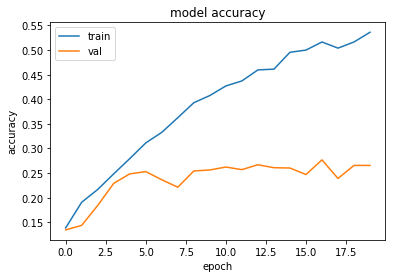

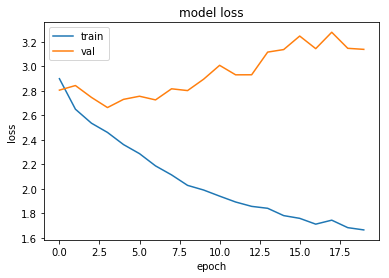

In [131]:
# Plot accuracy and loss curves
pp.plotAccuracyAndLoss(history.history)

In [132]:
pred_train_m = model.predict(x_train_m)
print('Done!')
pred_val_m = model.predict(x_val_m)
print('Done!')
pred_test_m = model.predict(x_test_m)
print('Done!')

Done!
Done!
Done!


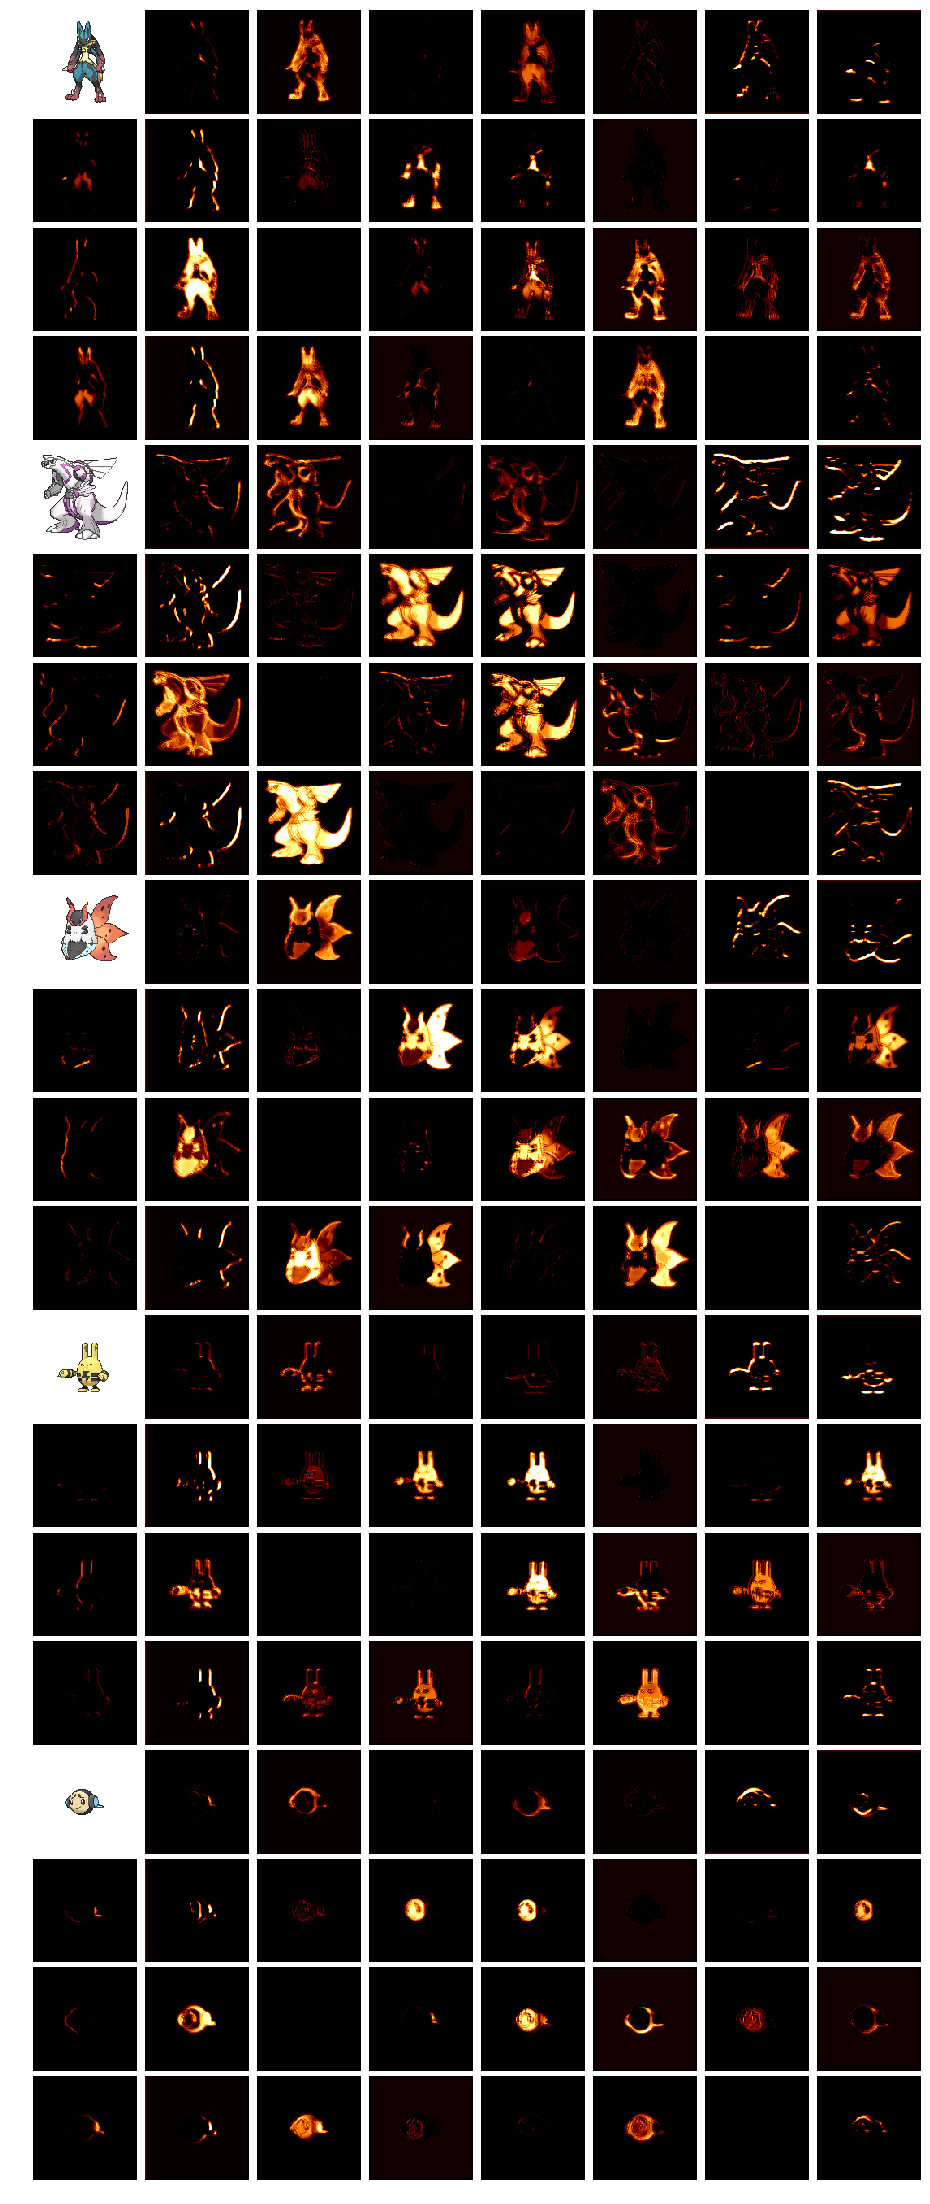

In [133]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import regularizers

# we build a new model with the activations of the old model
# this model is truncated after the first layer
model_trunc = Sequential([
    Conv2D(32, (5, 5), input_shape=(128,128,4), padding='same', 
           weights=model.layers[0].get_weights()),
    Activation("relu"),
])

start = 0
num = 50
step = 10

plt.figure(figsize=(16,8*num))
gs = gridspec.GridSpec(num*4,8)
gs.update(wspace=0.025, hspace=0.05)

idx = 0
for j in range(start, start+num, step):
    activations = model_trunc.predict(x_val_m[j].reshape(1,128,128,4))
    for i in range(0,32):        
        layer_filter = activations.reshape([128,128,32])[:,:,i]
        ax = plt.subplot(gs[32*idx+i])
        plt.axis("off")  
        if i == 0:
            plt.imshow(x_val_i[j])
        else:
            plt.imshow(layer_filter,cmap="afmhot",vmin=0, vmax=1)
    idx += 1

In [134]:
# Get secondary typing 
y_train_2, y_val_2, y_test_2 = utils.getSecondaryTypeLabels()

y_train_2: (6010,)
y_val_2:   (1510,)
y_test_2:  (1880,)


In [135]:
# Averages scores across frames of pokemon's animation  
metrics_train = customPredict(pred_train_m, y_train_m, y2=y_train_2)
metrics_val = customPredict(pred_val_m, y_val_m, y2=y_val_2)
metrics_test = customPredict(pred_test_m, y_test_m, y2=y_test_2)

titles = ("Train", "Validation", "Test")
mets = (metrics_train, metrics_val, metrics_test)
for i in range(3):
    met = mets[i]
    print(titles[i])
    for k in met.keys():
        if not k in ["avg_scores", "avg_predictions", "predictions", "confusion_mat"]:
            print(k + ":\t", met[k])
    print()

Train
acc:	 0.6554076539101498
avg_acc:	 0.6738768718801996
avg_acc_2:	 0.6838602329450915
avg_precision:	 0.5755458248310675
avg_recall:	 0.7120552488701384

Validation
acc:	 0.2768211920529801
avg_acc:	 0.271523178807947
avg_acc_2:	 0.2913907284768212
avg_precision:	 0.24434984520123837
avg_recall:	 0.2531963768885942

Test
acc:	 0.2824468085106383
avg_acc:	 0.2925531914893617
avg_acc_2:	 0.31382978723404253
avg_precision:	 0.21692538126361655
avg_recall:	 0.2635413386432408



/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


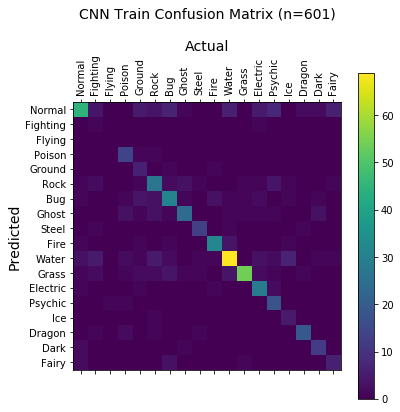

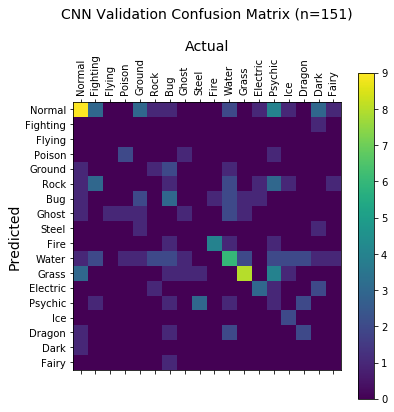

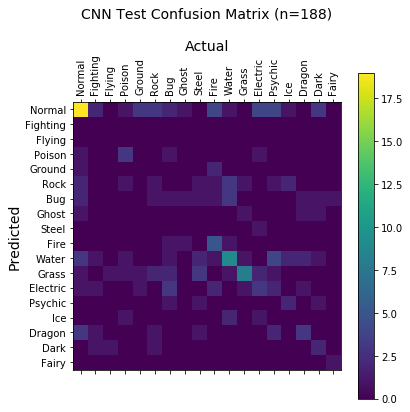

In [136]:
# Plot confusion matrix
pp.plotConfusionMatrix(metrics_train['confusion_mat'], "CNN Train")
pp.plotConfusionMatrix(metrics_val['confusion_mat'], "CNN Validation")
pp.plotConfusionMatrix(metrics_test['confusion_mat'], "CNN Test")

Train predictions


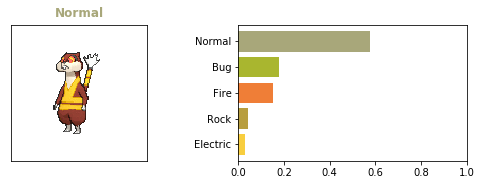

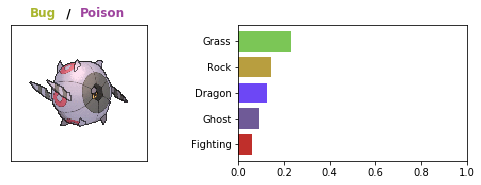

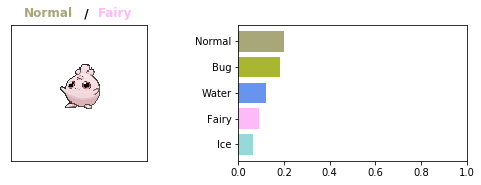

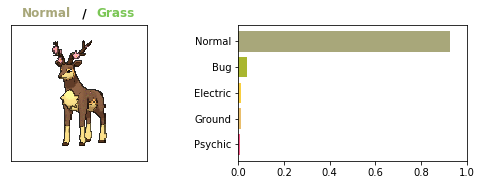

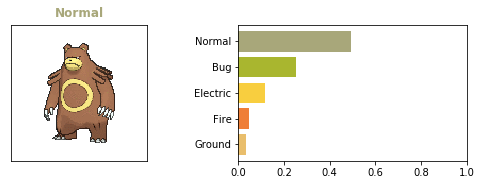

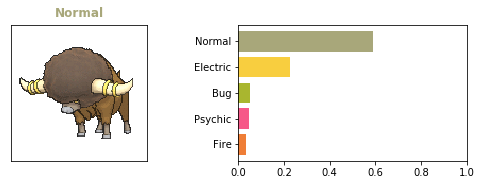

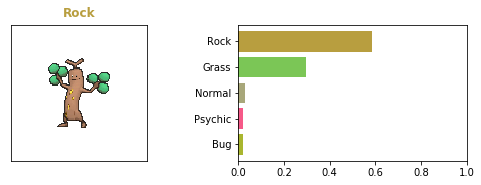

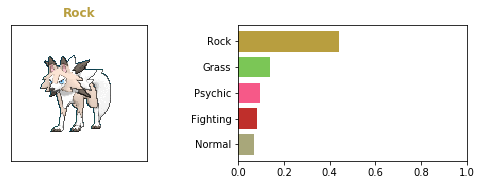

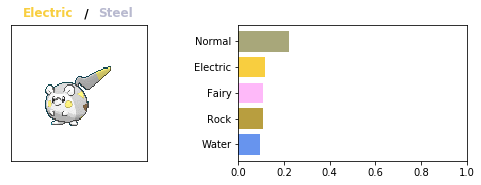

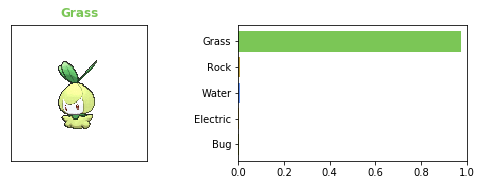

In [155]:
start = 100  # start index
num = 10    # number of images to display
step = 10  # number of frames / pokemon animation

print("Train predictions")
pp.plotPredictions(x_train_i[start*step:(start+num)*step:step],
                   y_train_m[start*step:(start+num)*step:step],
                   metrics_train["avg_scores"][start:start+num:1], k=5, y2=y_train_2[start*step:(start+num)*step:step])

Validation predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


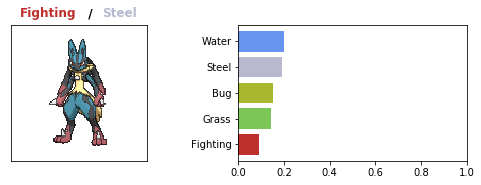

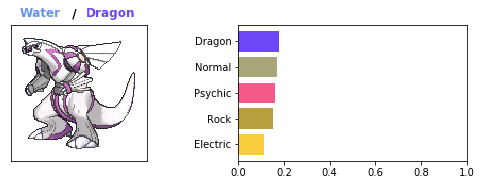

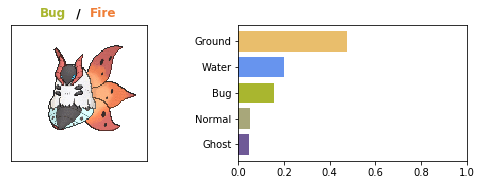

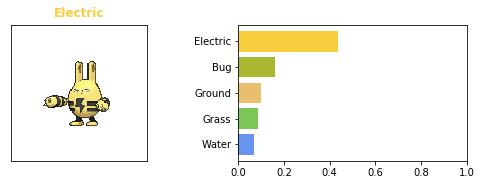

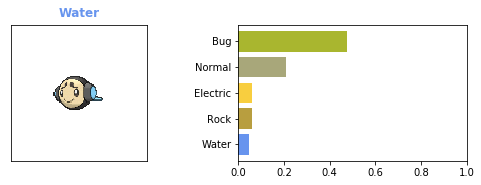

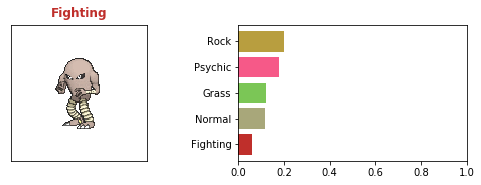

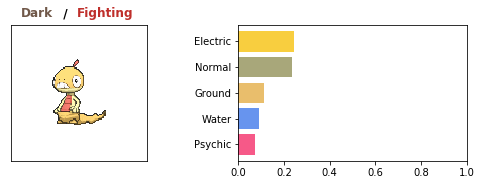

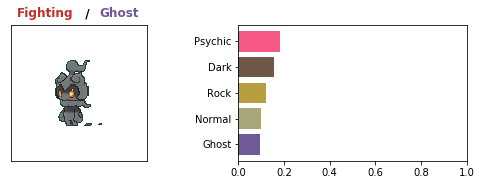

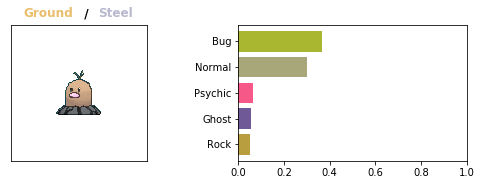

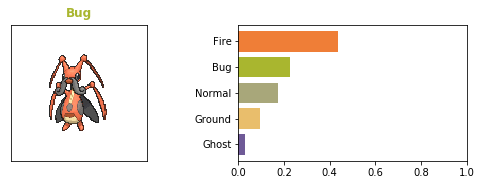

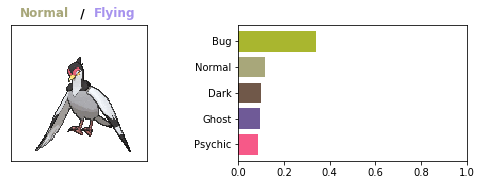

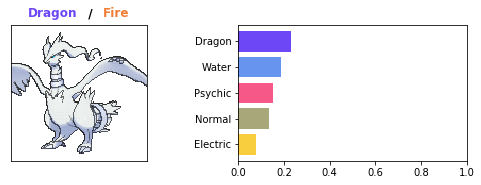

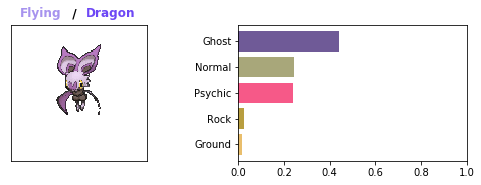

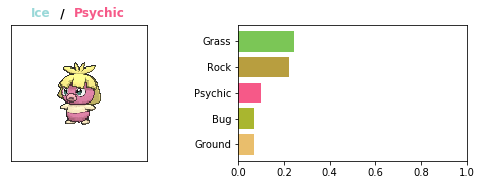

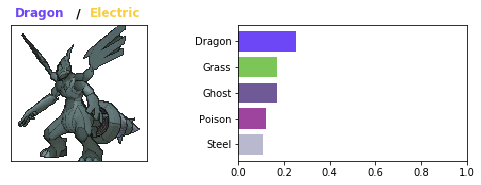

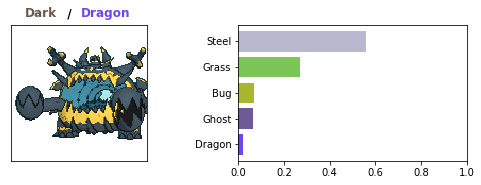

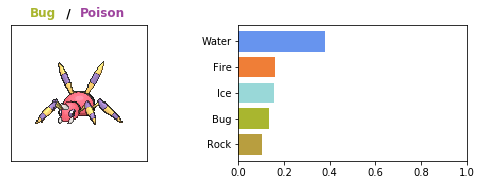

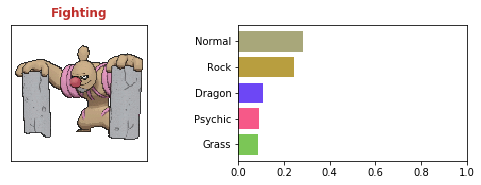

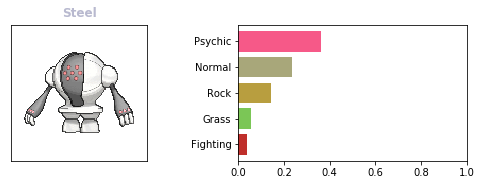

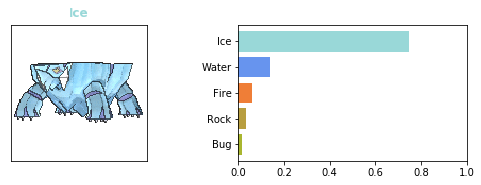

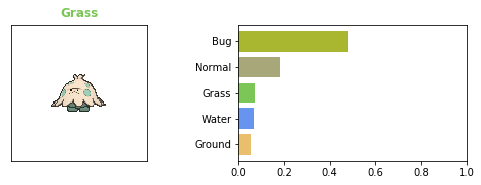

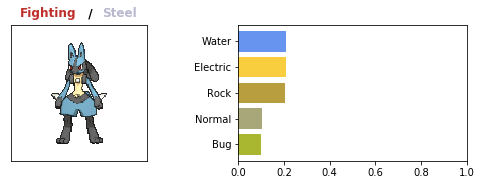

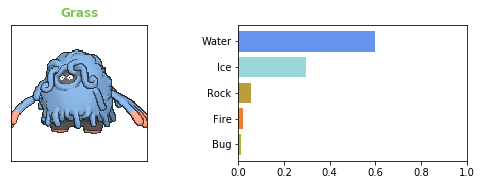

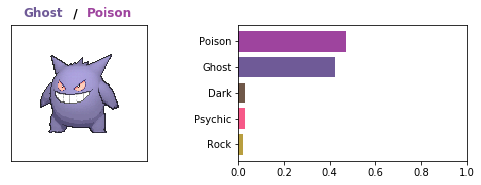

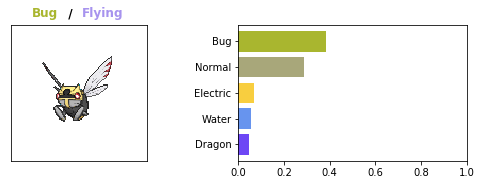

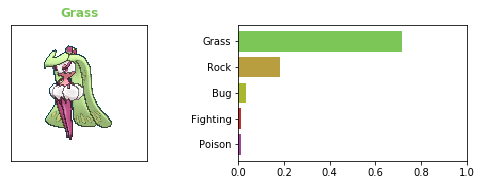

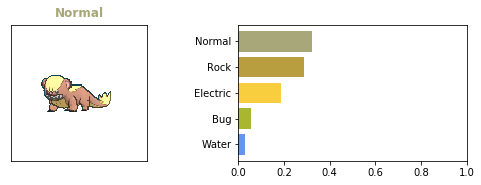

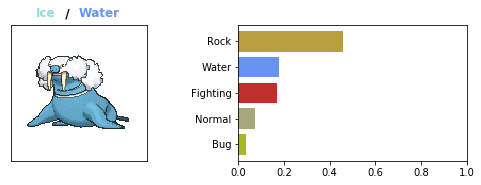

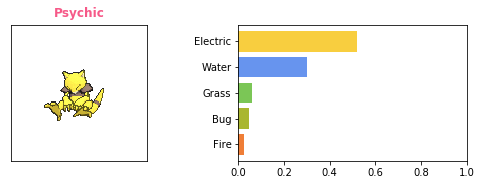

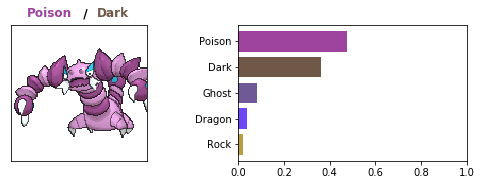

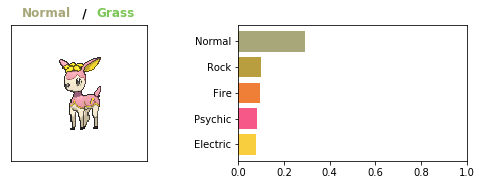

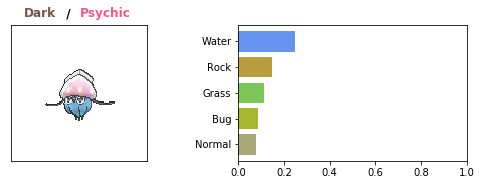

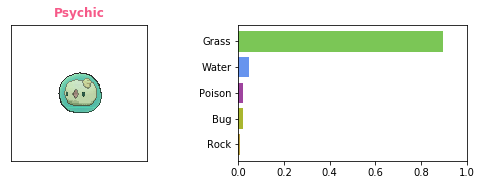

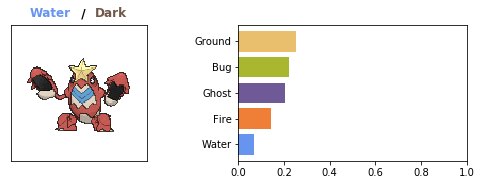

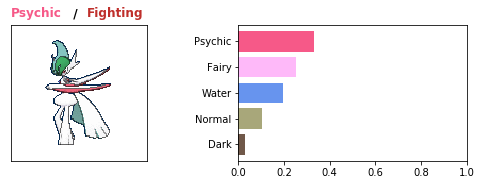

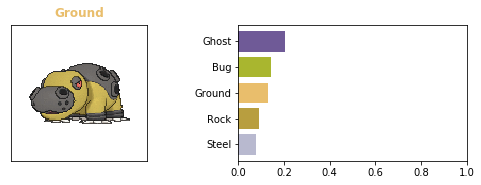

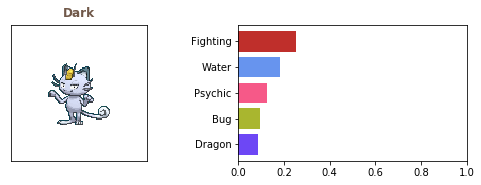

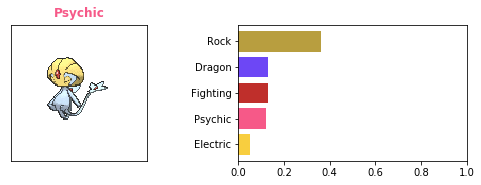

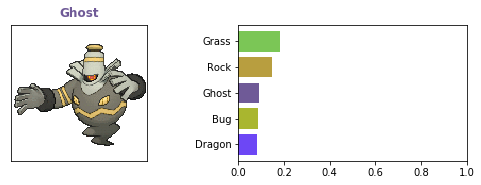

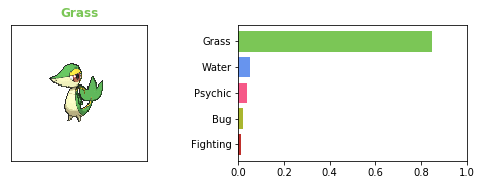

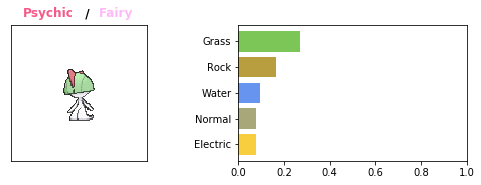

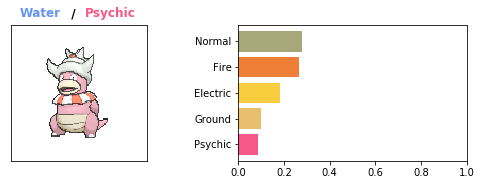

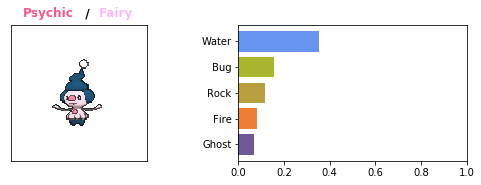

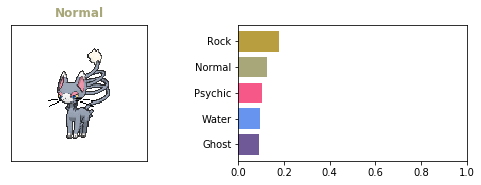

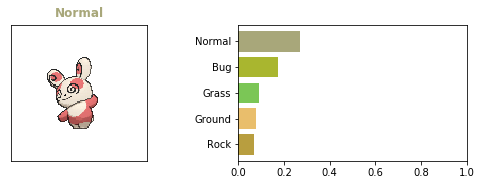

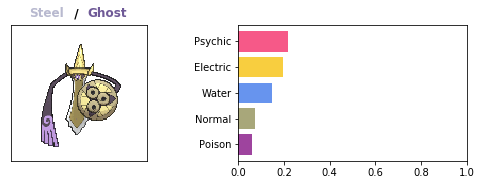

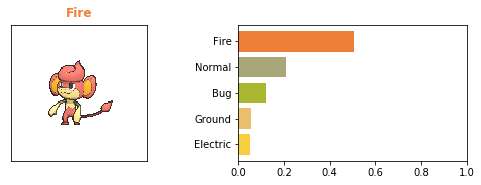

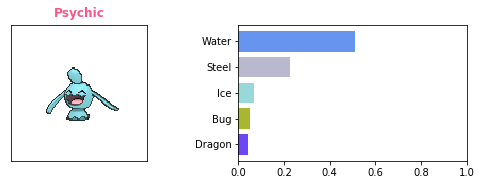

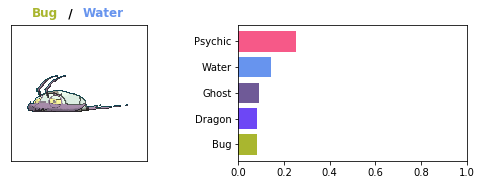

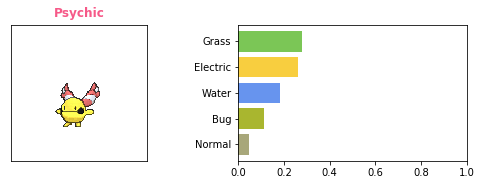

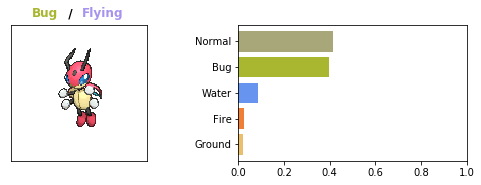

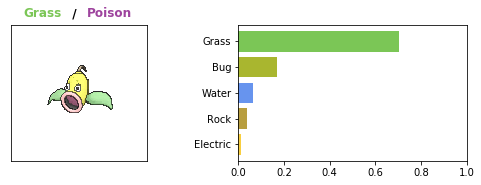

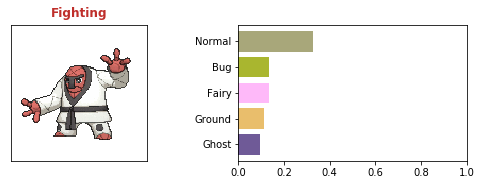

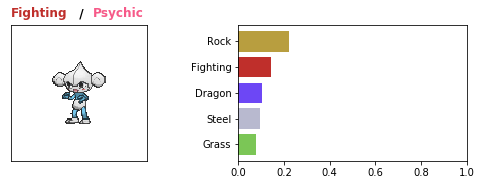

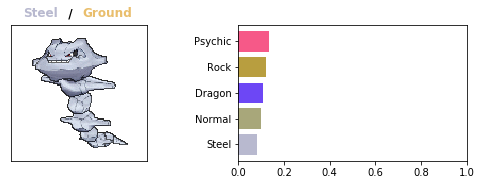

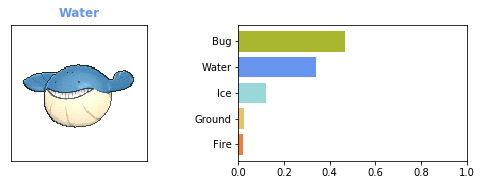

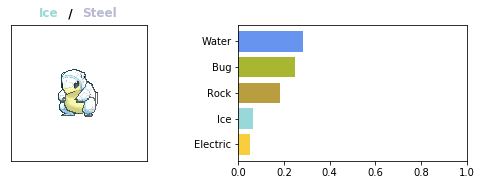

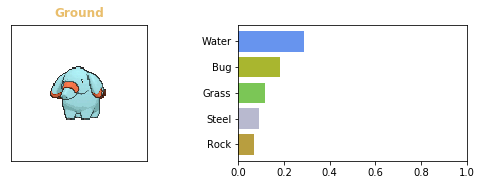

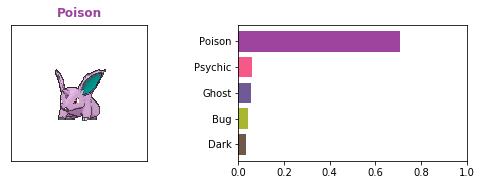

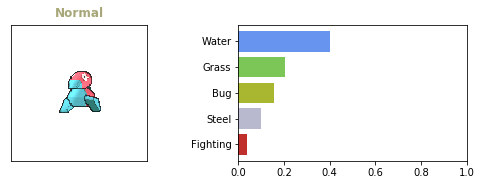

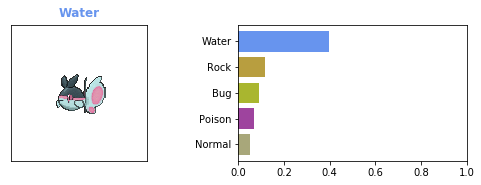

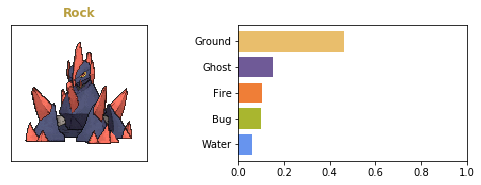

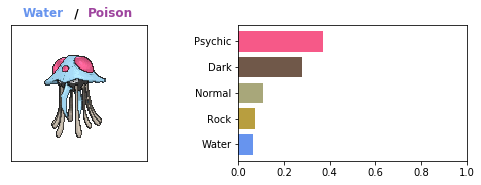

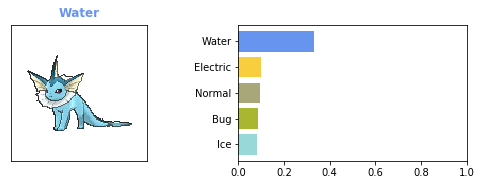

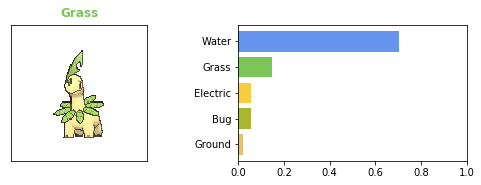

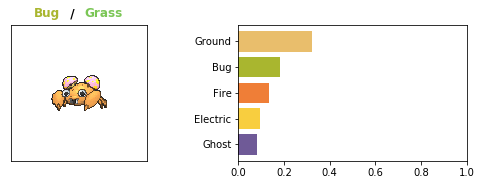

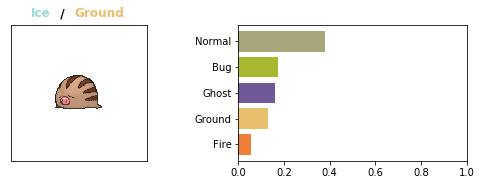

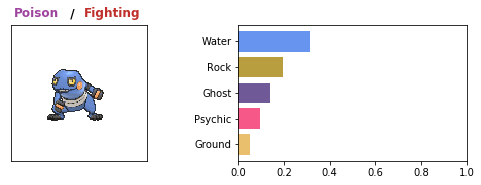

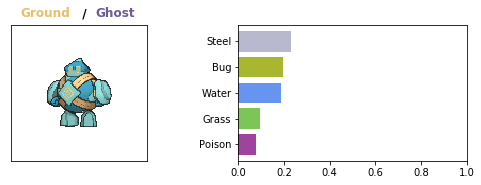

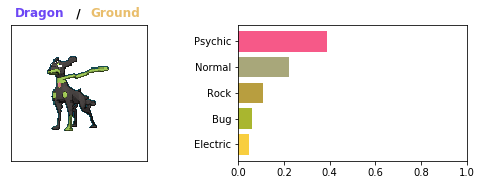

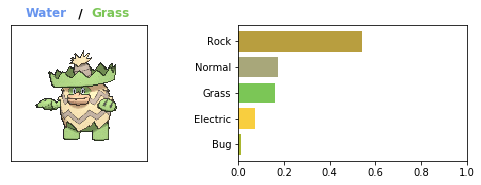

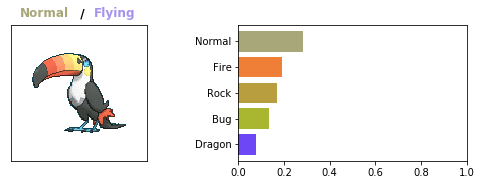

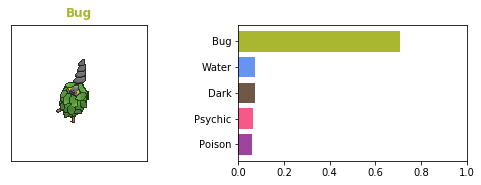

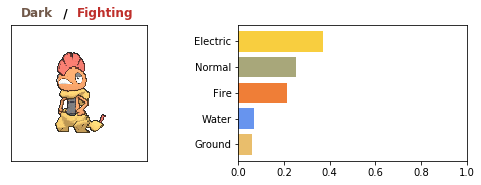

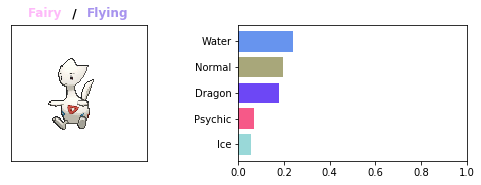

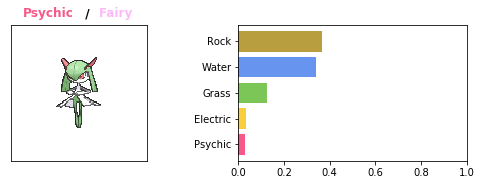

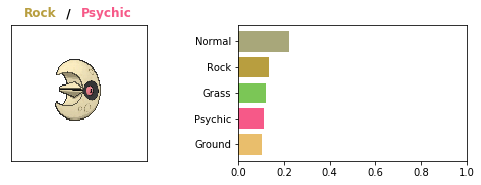

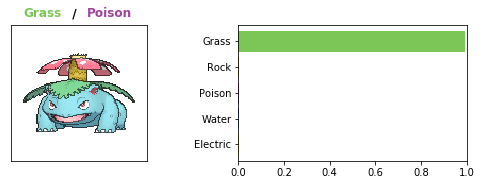

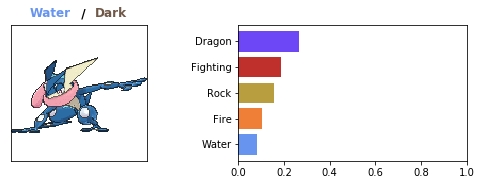

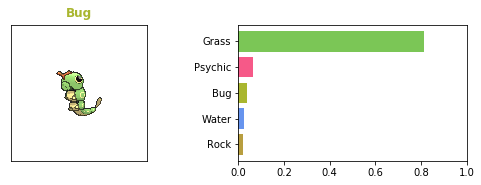

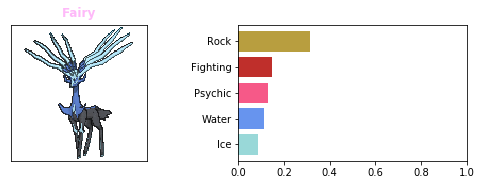

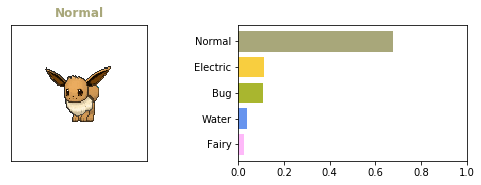

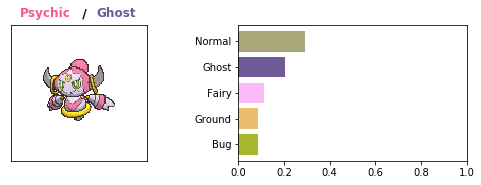

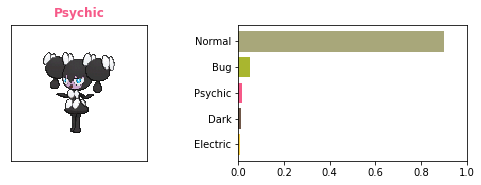

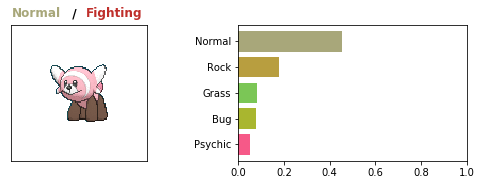

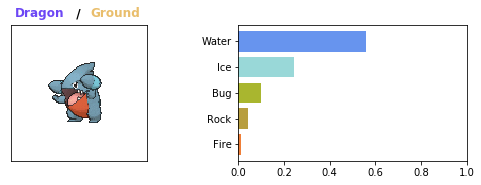

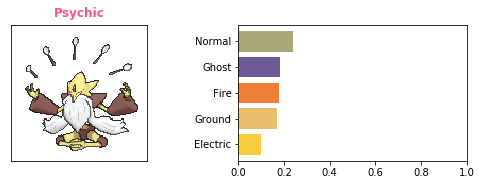

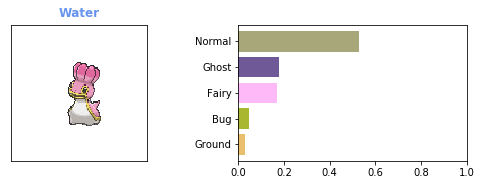

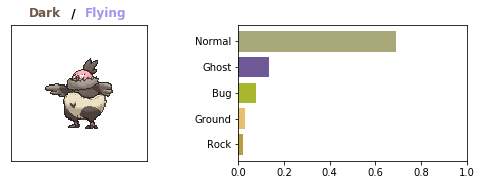

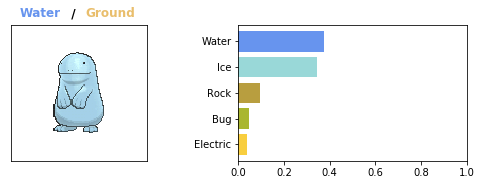

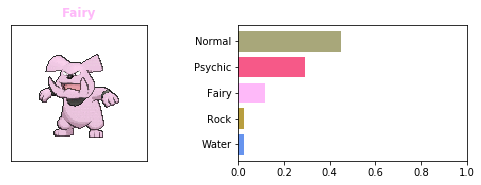

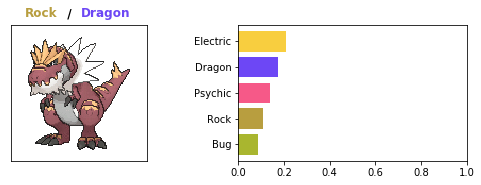

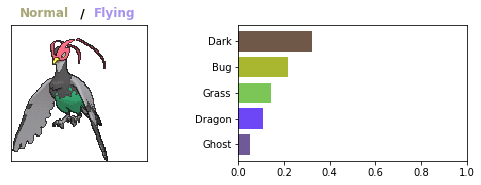

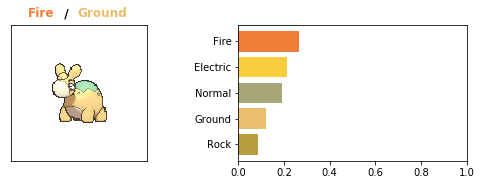

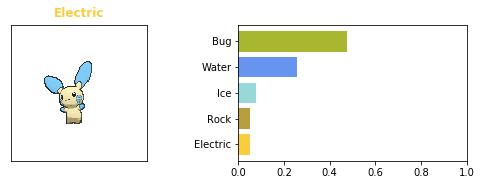

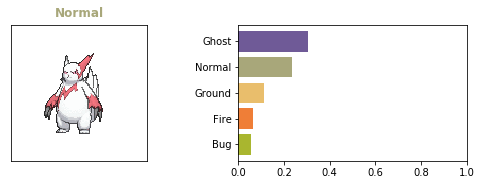

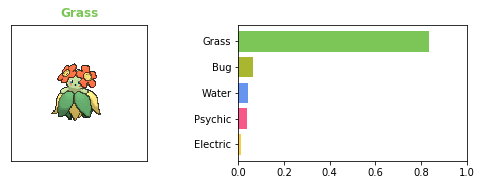

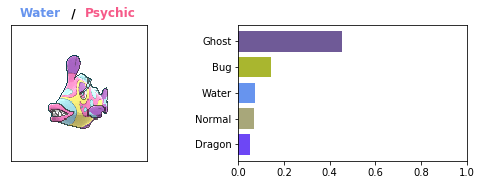

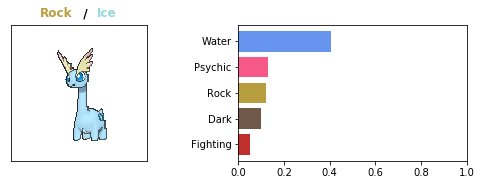

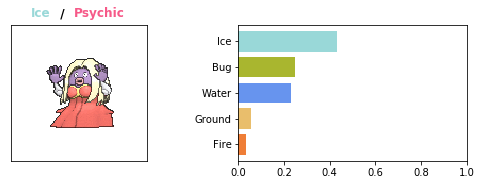

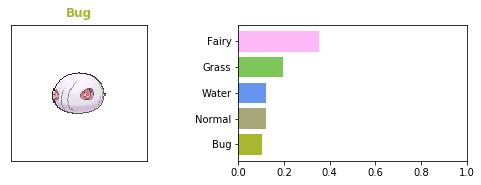

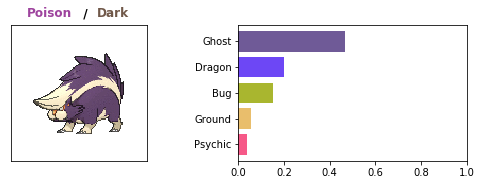

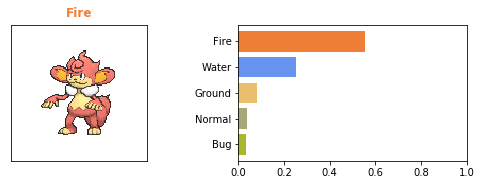

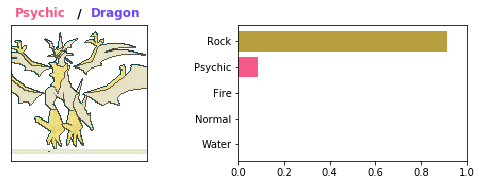

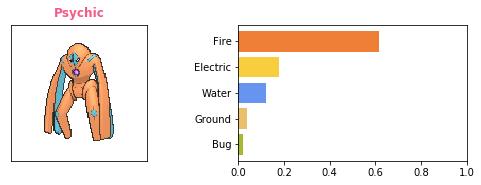

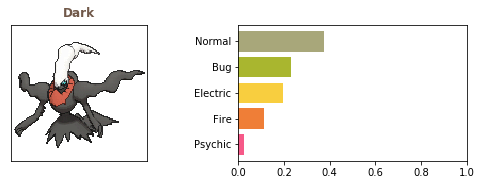

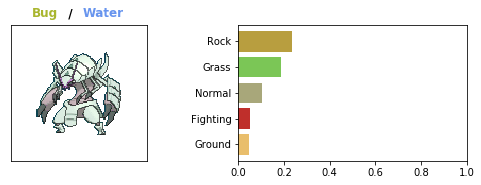

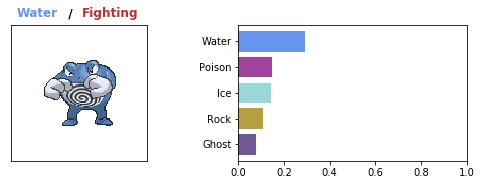

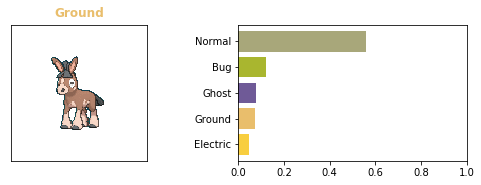

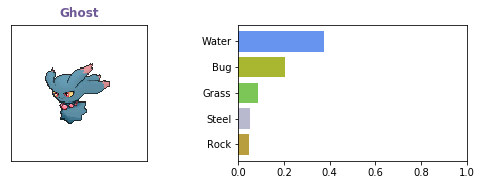

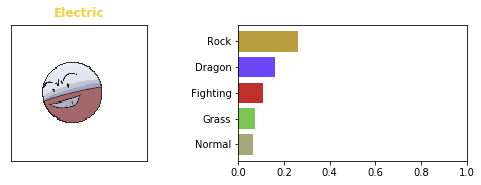

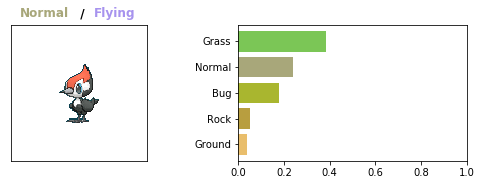

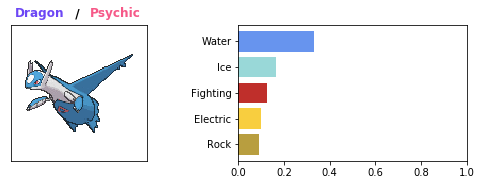

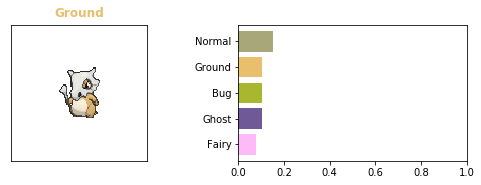

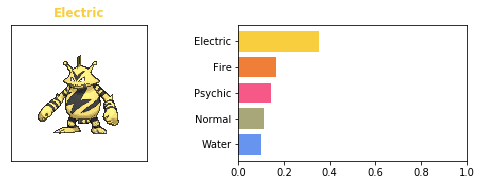

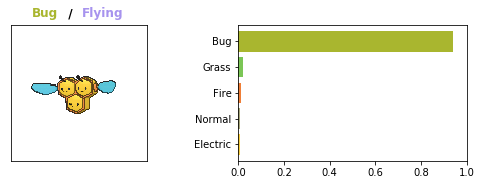

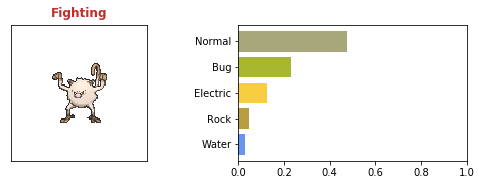

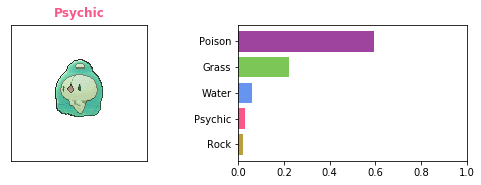

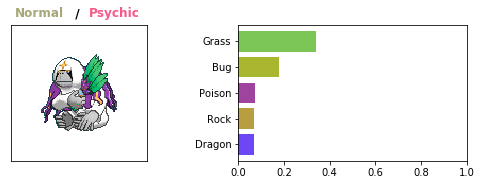

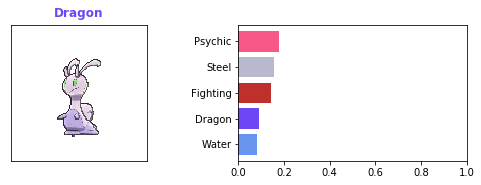

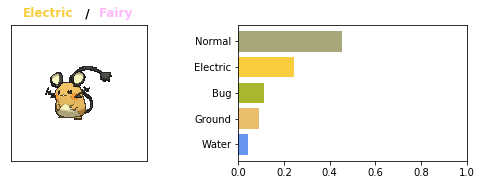

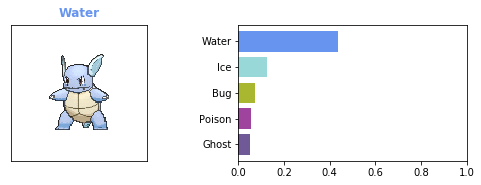

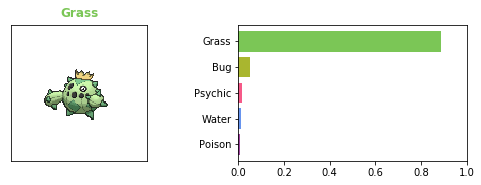

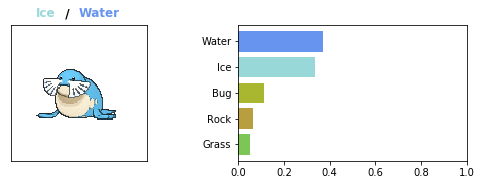

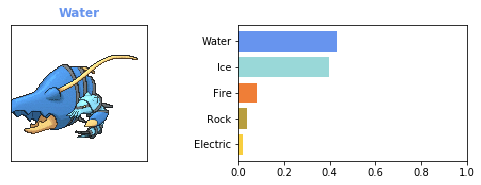

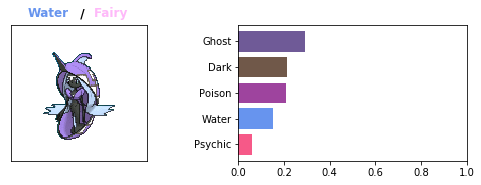

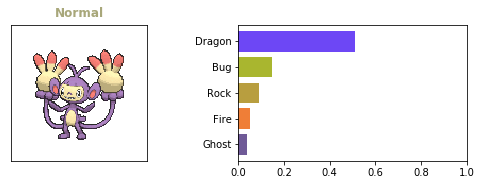

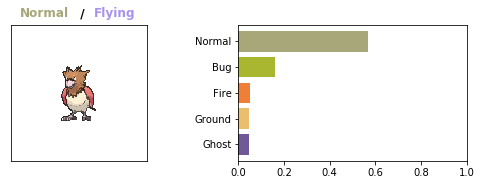

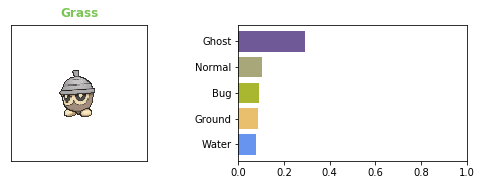

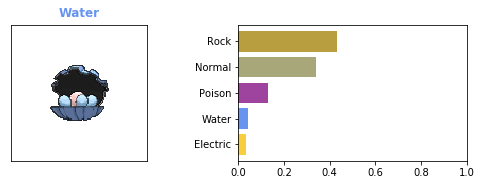

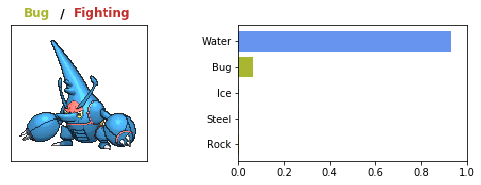

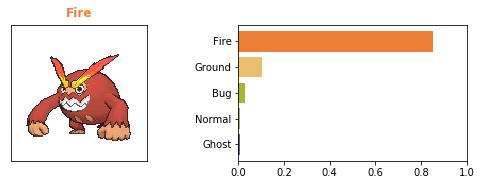

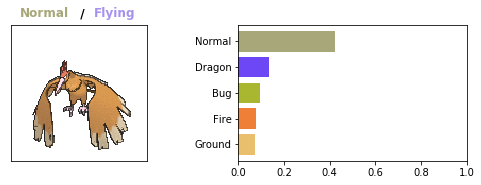

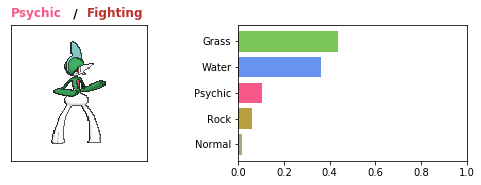

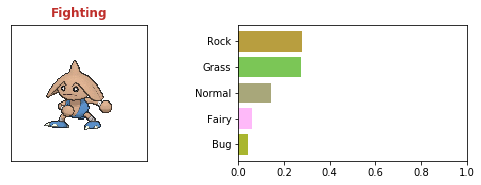

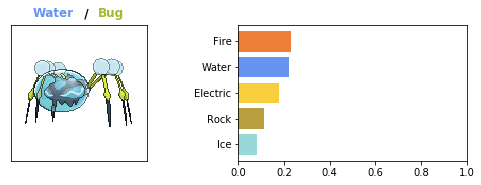

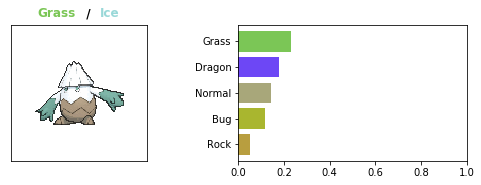

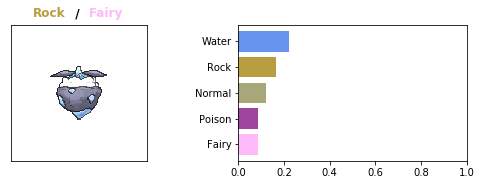

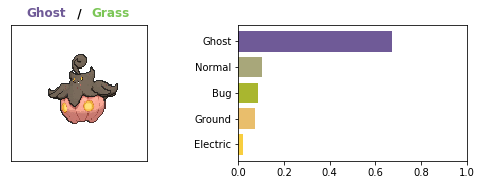

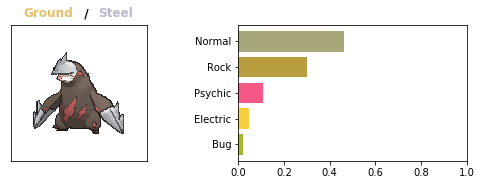

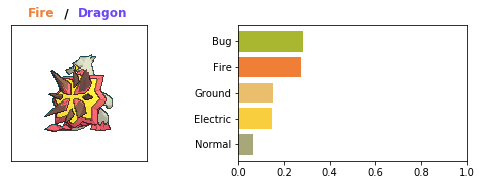

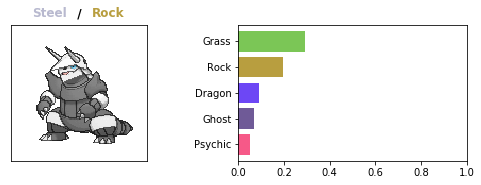

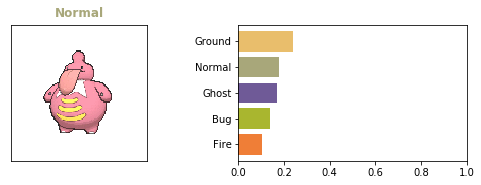

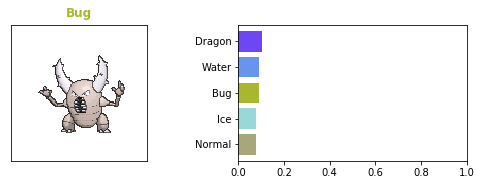

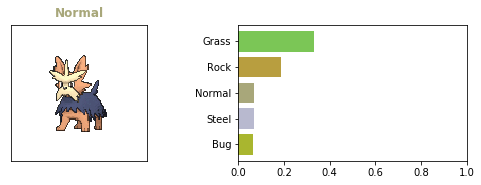

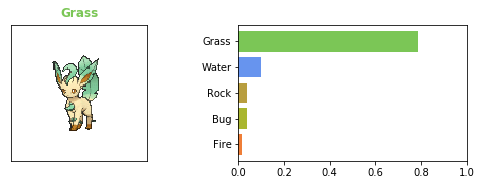

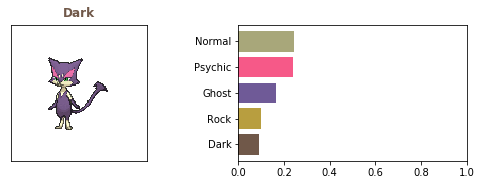

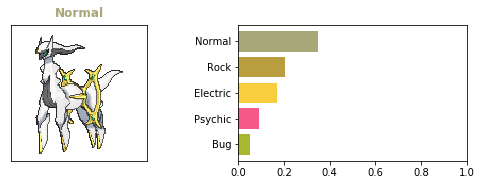

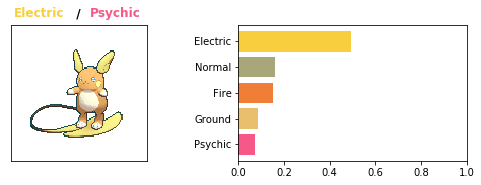

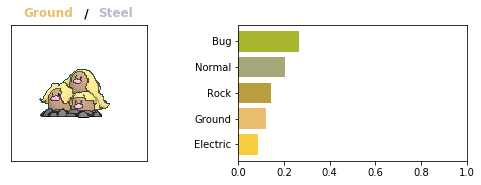

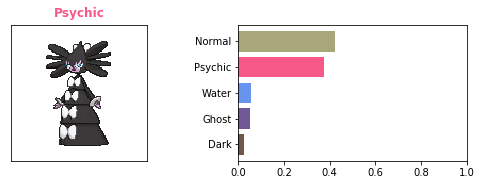

In [156]:
start = 0  # start index
num = 200    # number of images to display
step = 10  # number of frames / pokemon animation

print("Validation predictions")
pp.plotPredictions(x_val_i[start*step:(start+num)*step:step],
                   y_val_m[start*step:(start+num)*step:step],
                   metrics_val["avg_scores"][start:start+num:1], k=5, y2=y_val_2[start*step:(start+num)*step:step])

Test predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


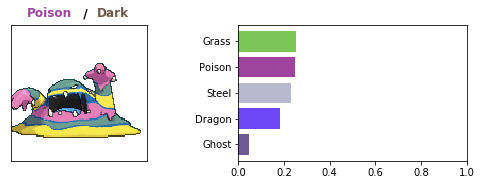

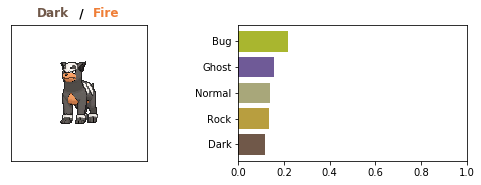

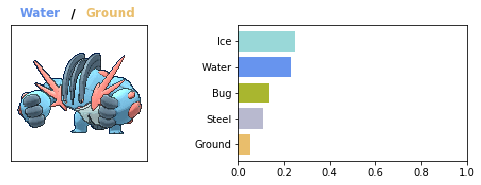

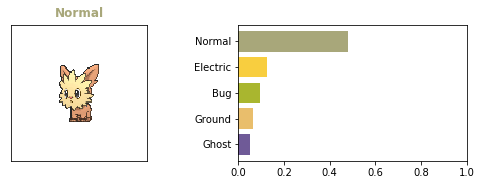

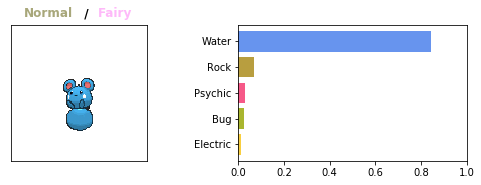

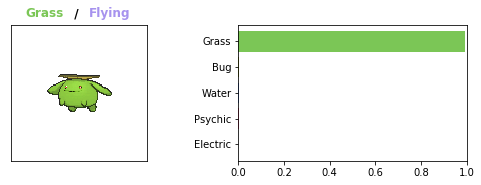

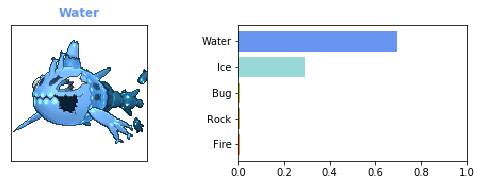

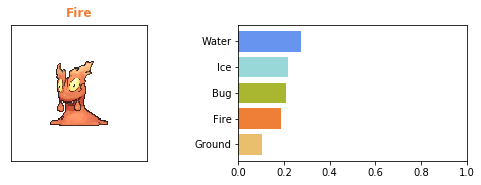

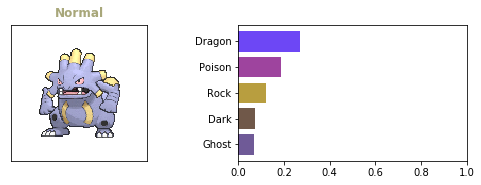

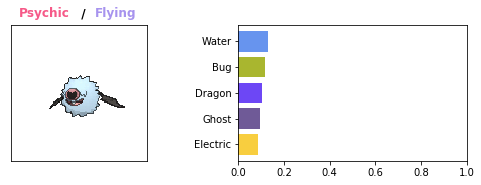

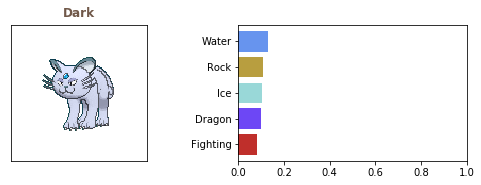

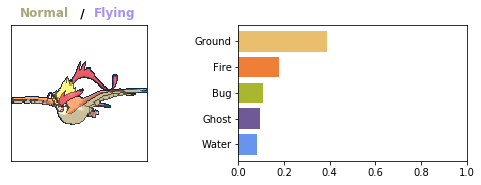

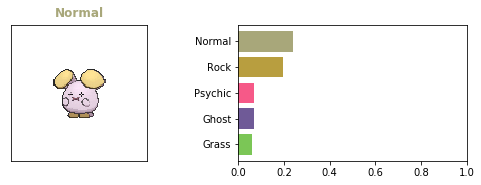

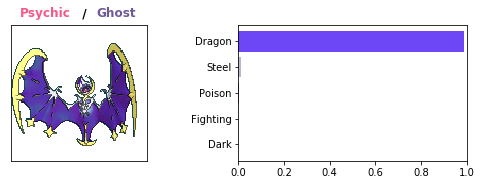

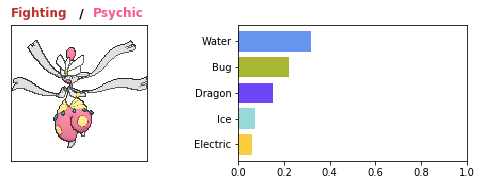

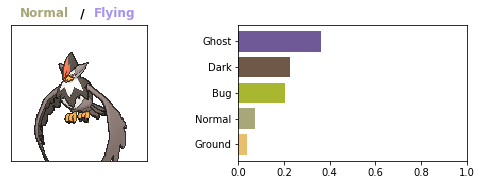

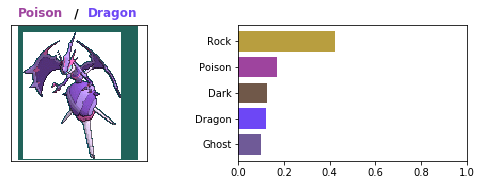

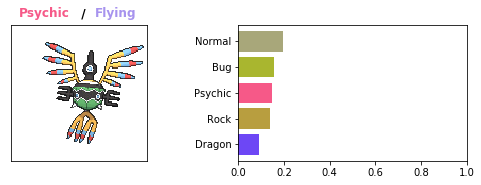

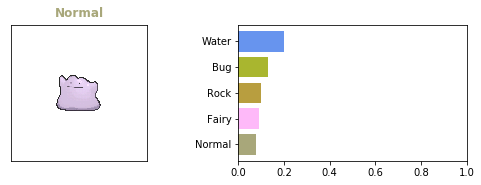

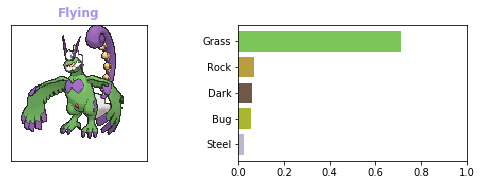

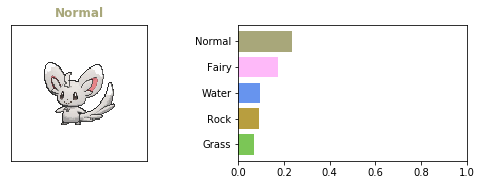

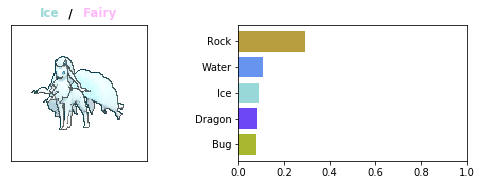

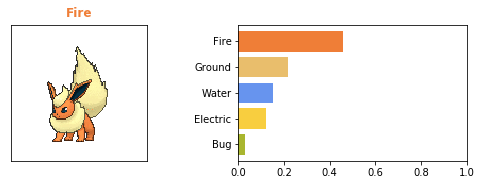

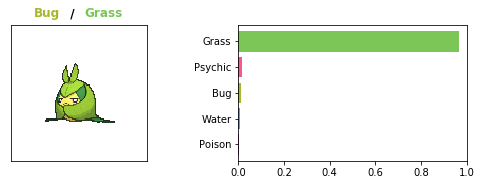

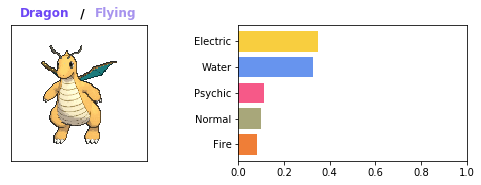

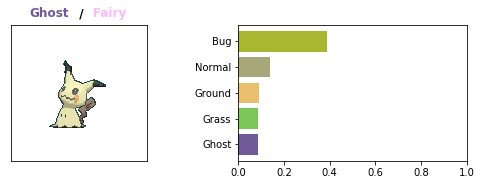

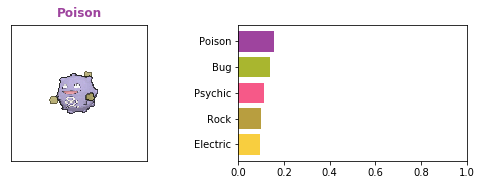

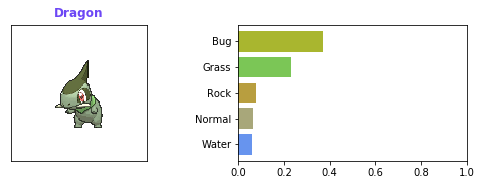

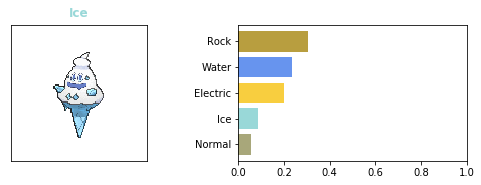

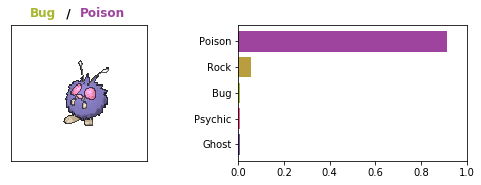

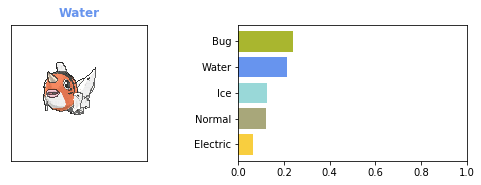

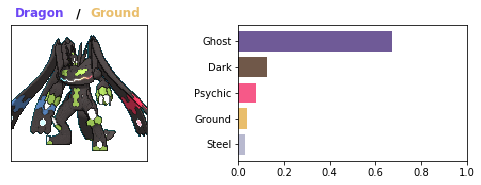

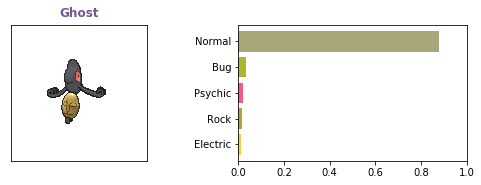

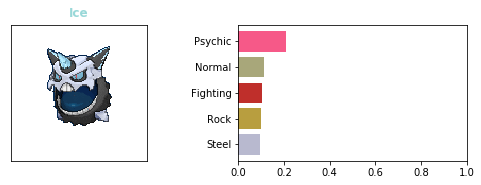

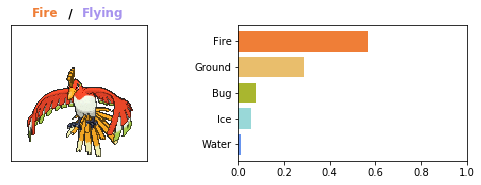

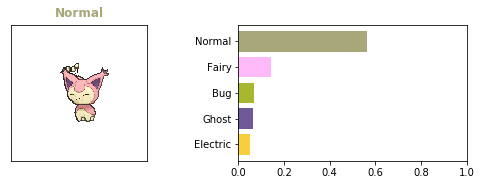

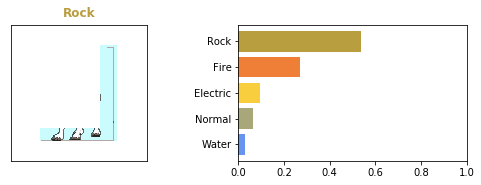

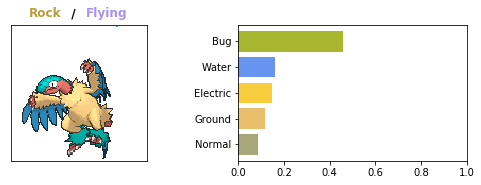

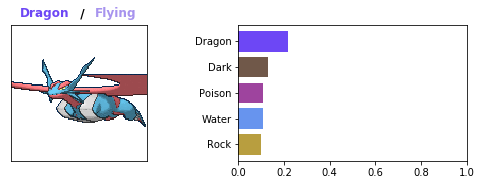

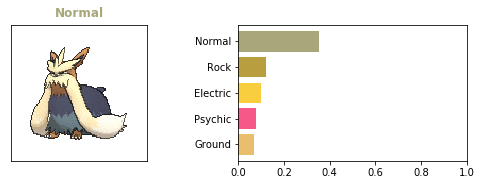

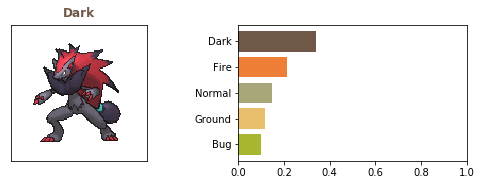

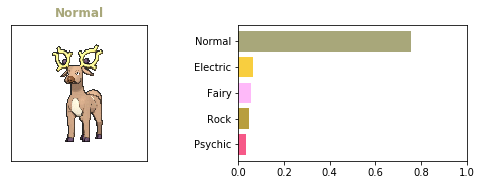

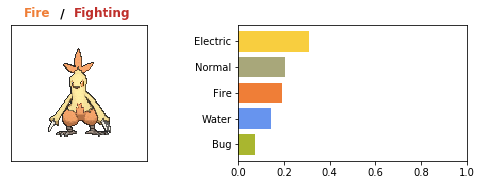

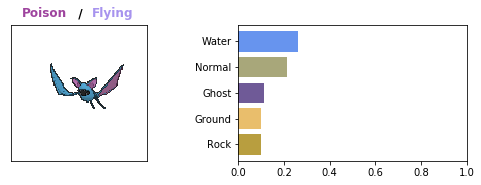

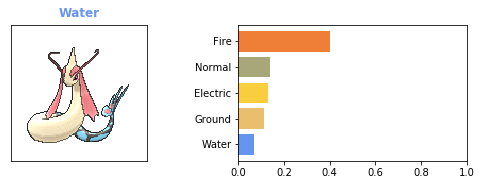

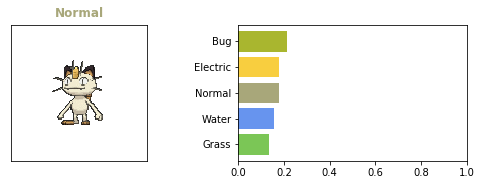

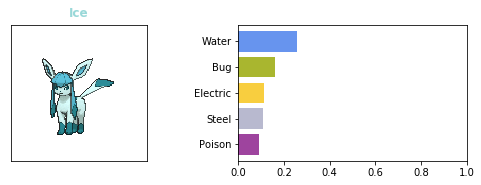

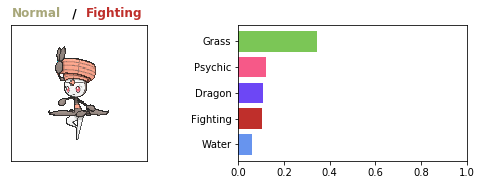

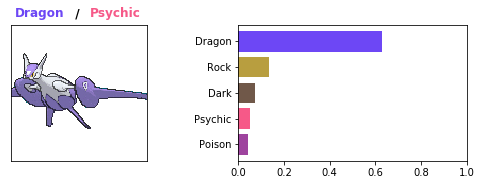

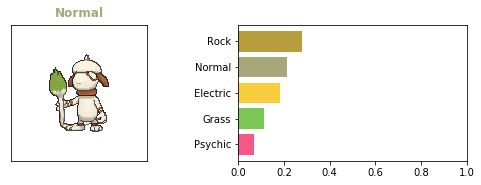

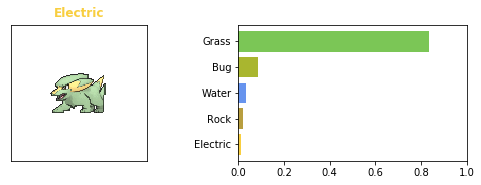

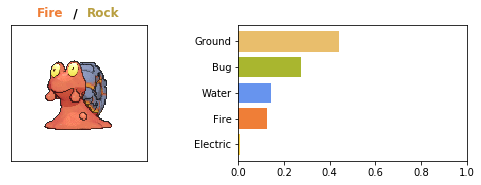

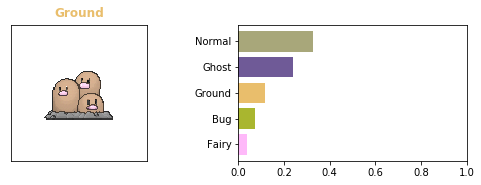

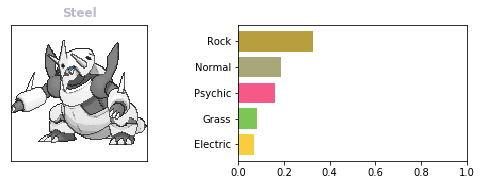

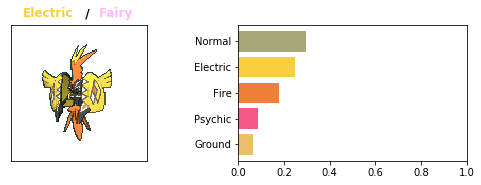

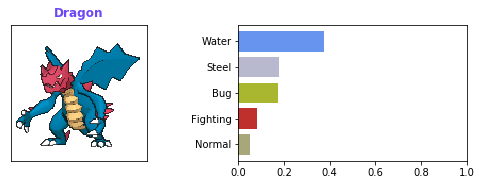

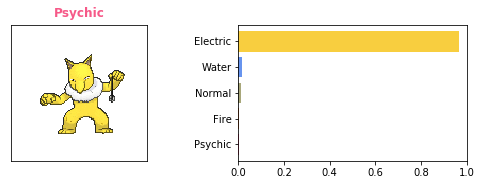

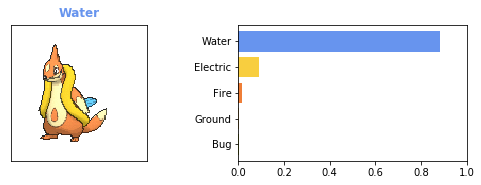

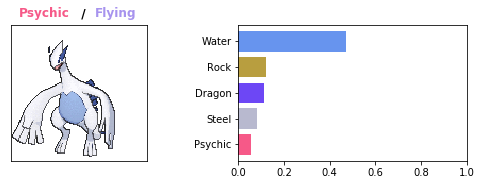

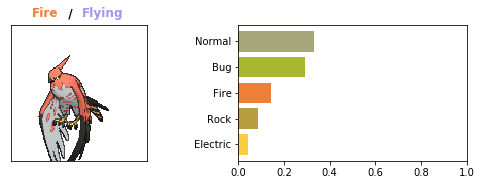

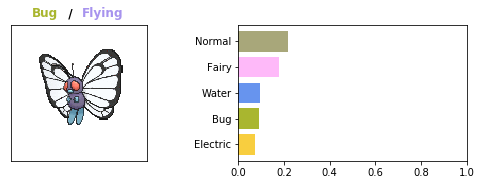

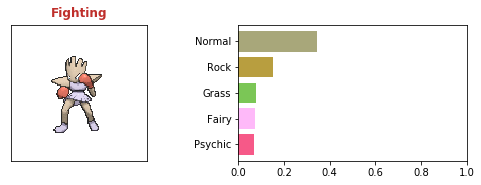

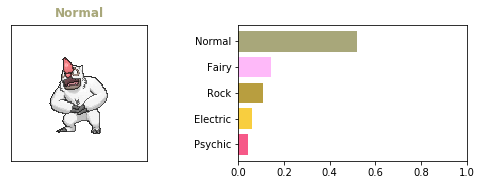

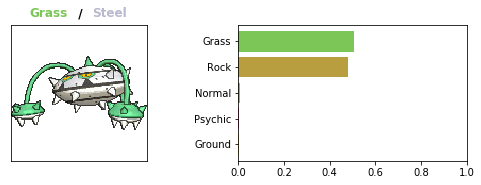

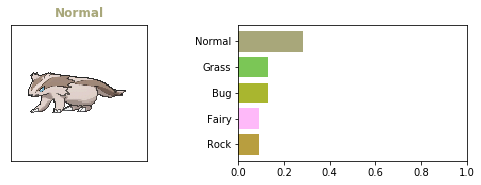

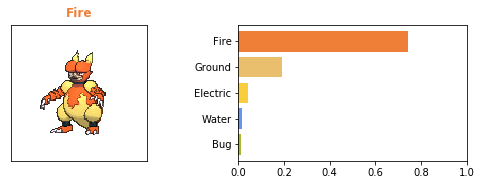

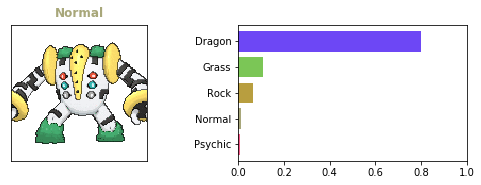

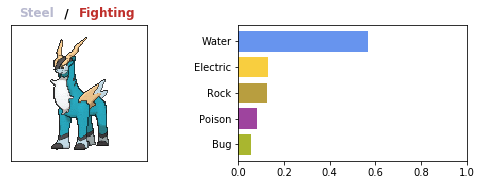

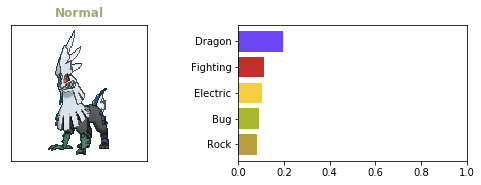

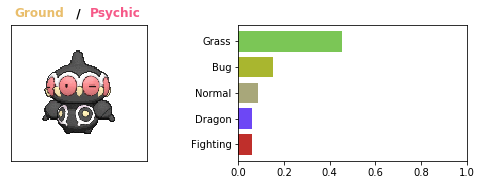

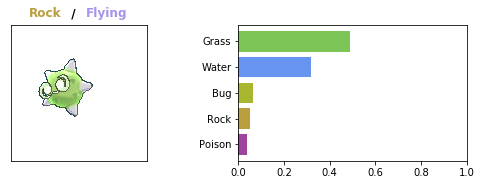

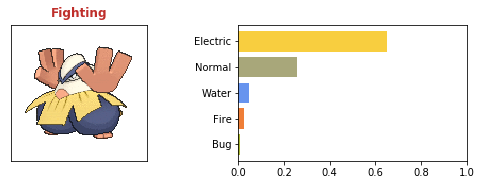

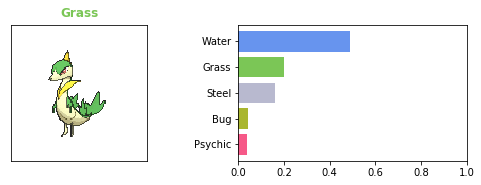

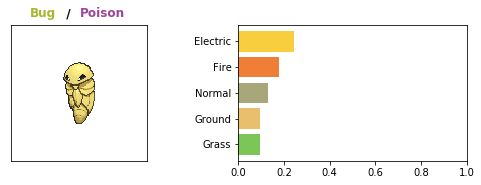

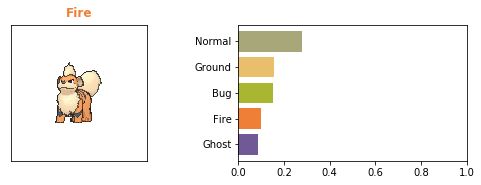

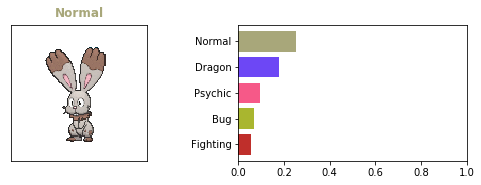

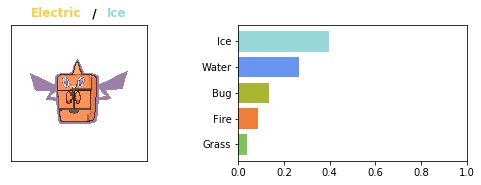

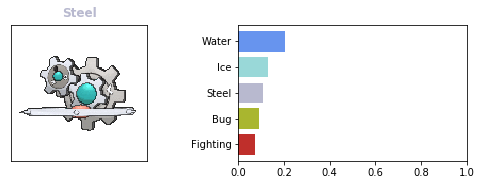

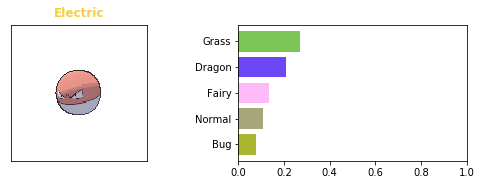

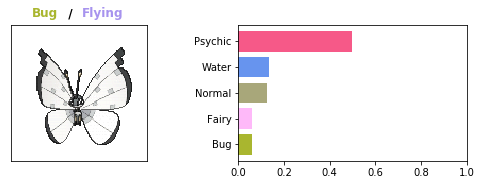

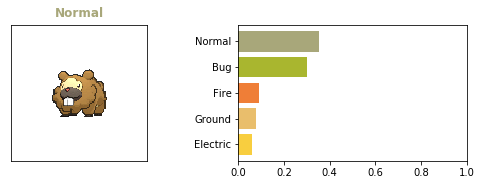

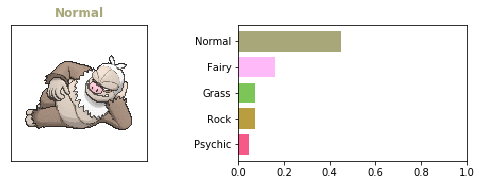

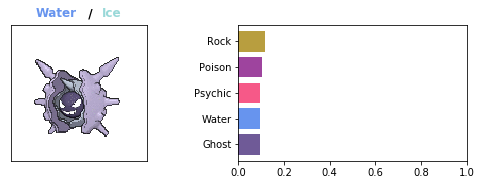

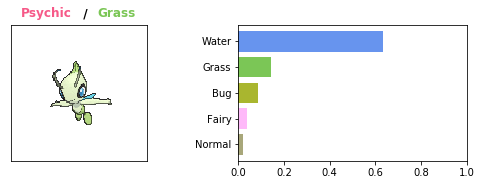

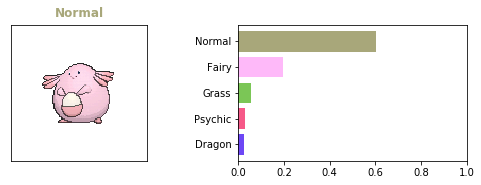

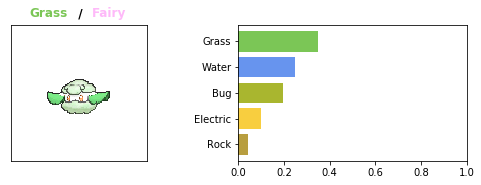

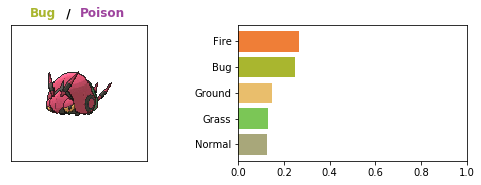

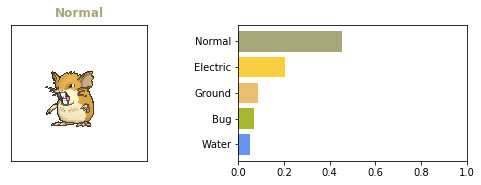

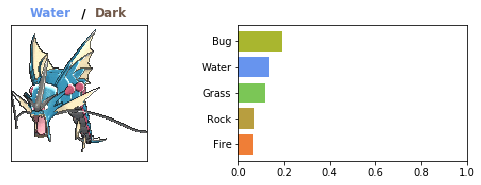

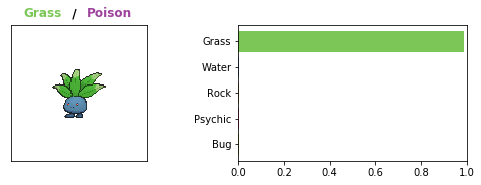

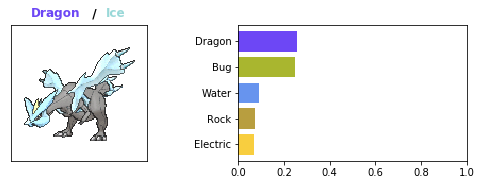

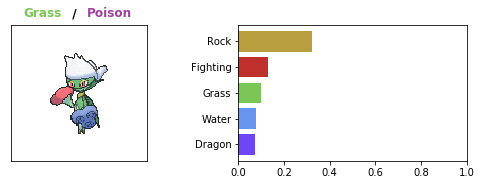

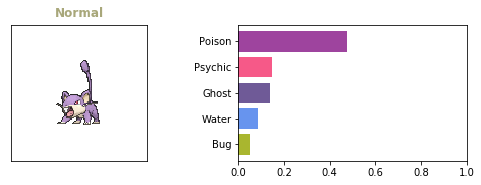

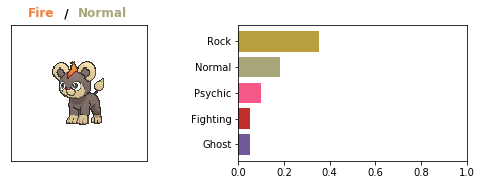

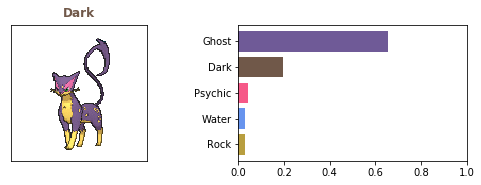

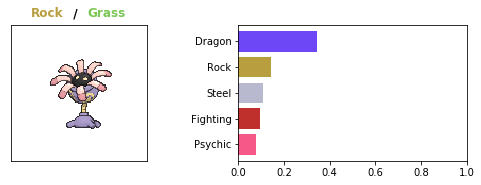

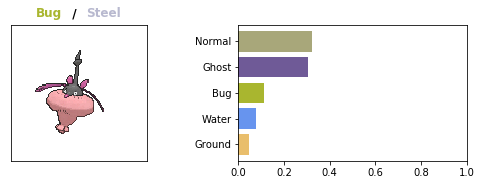

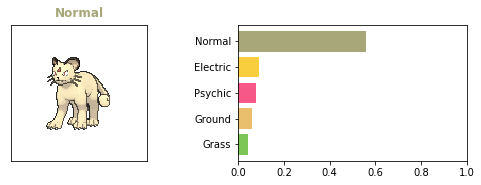

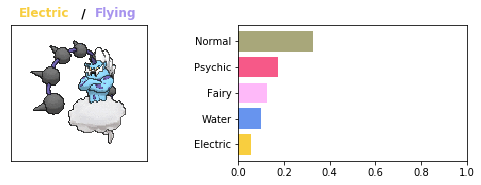

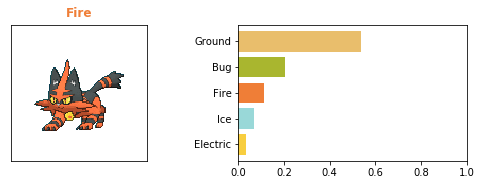

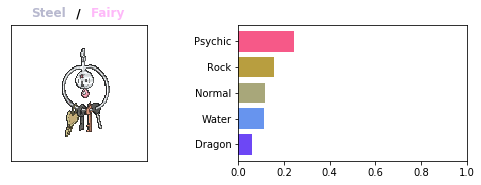

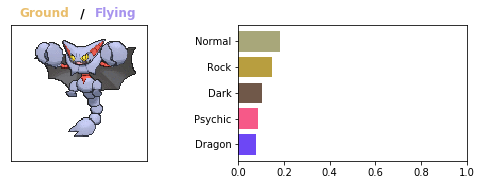

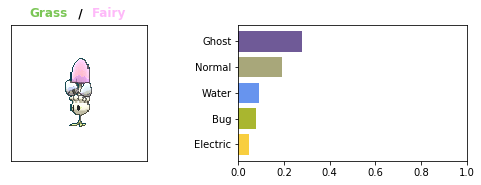

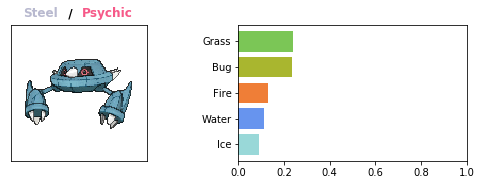

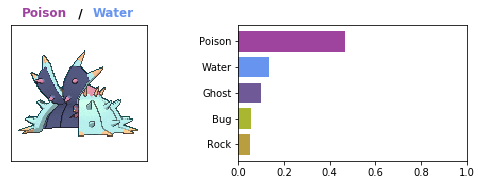

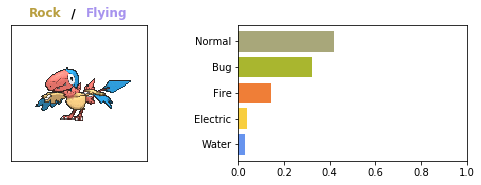

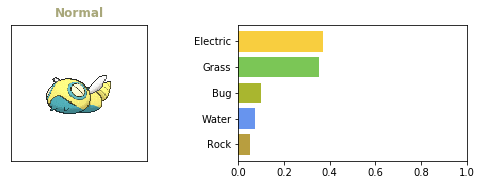

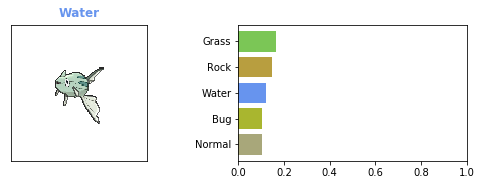

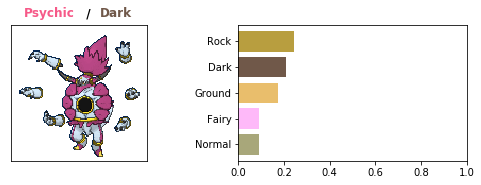

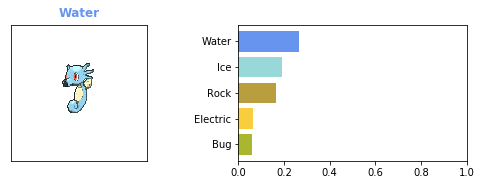

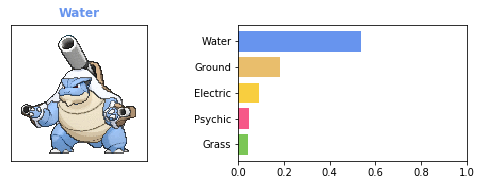

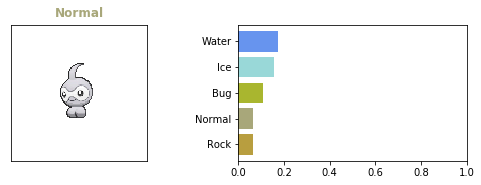

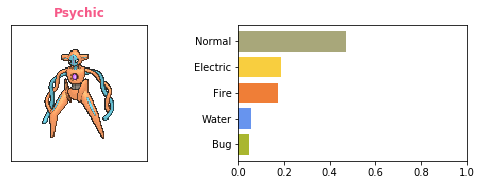

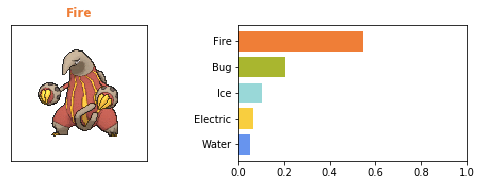

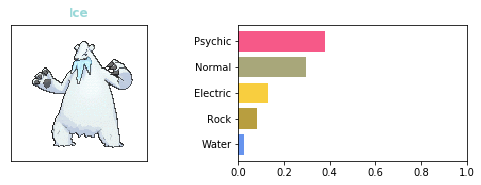

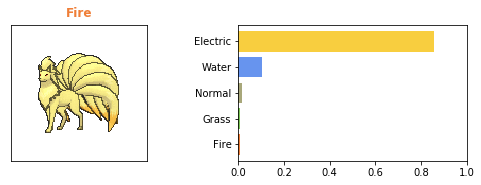

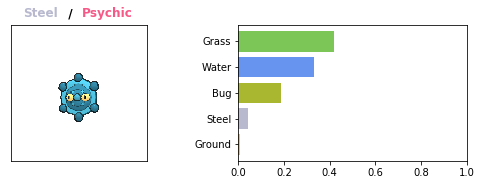

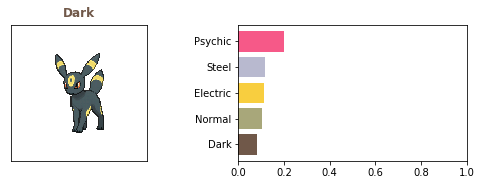

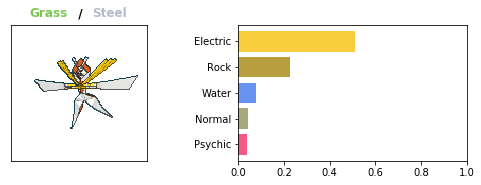

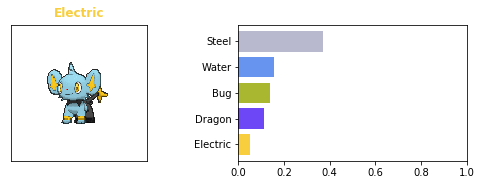

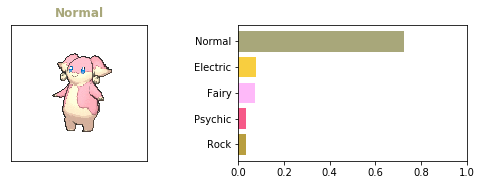

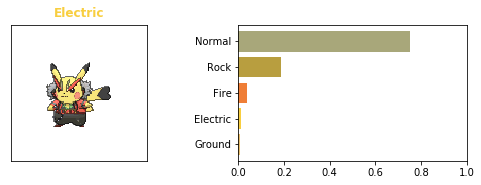

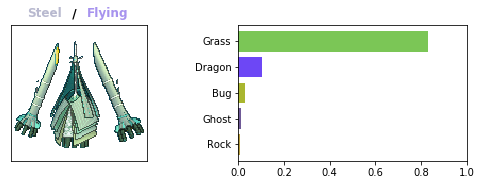

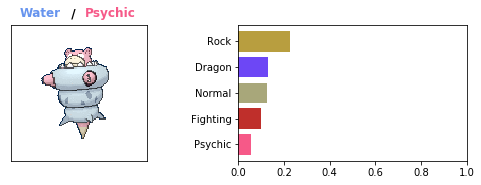

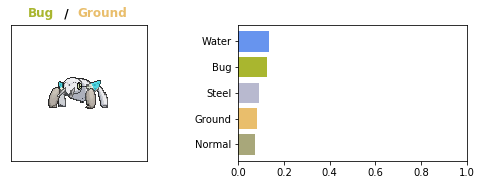

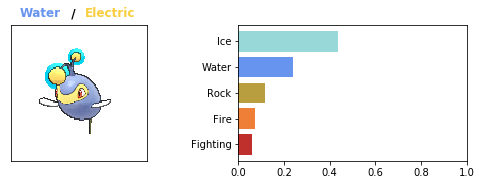

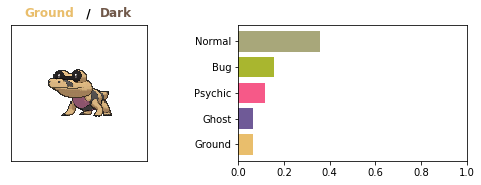

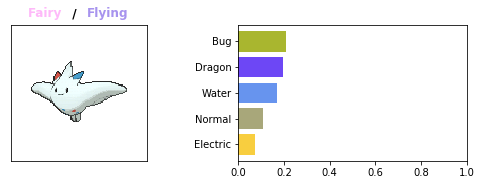

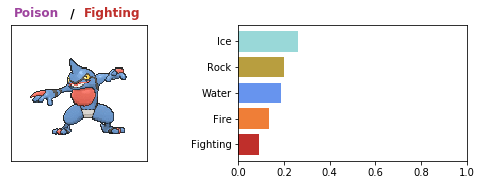

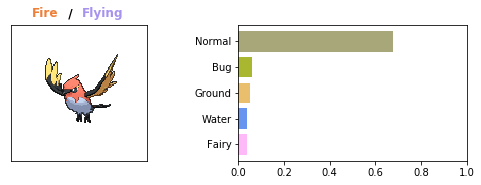

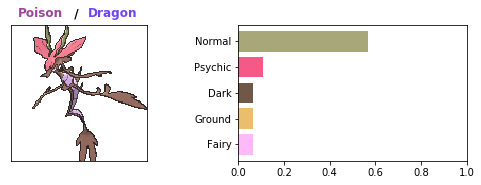

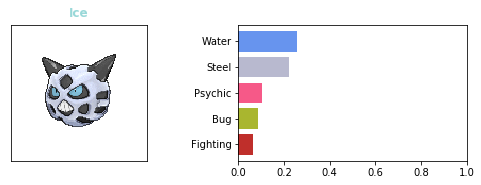

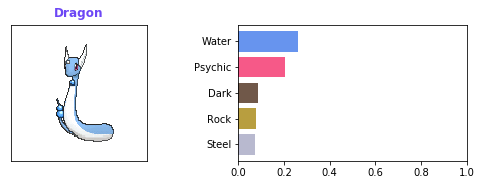

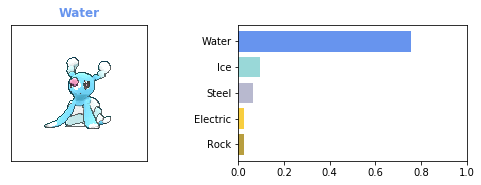

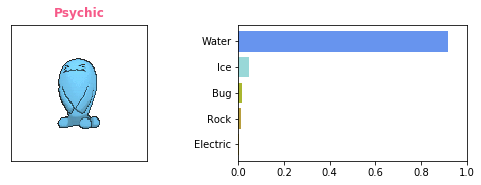

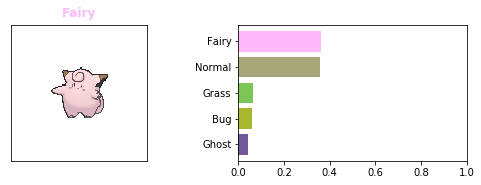

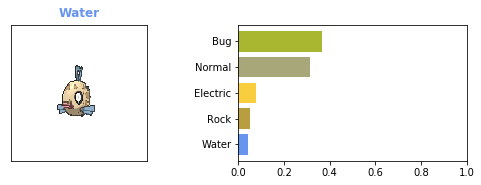

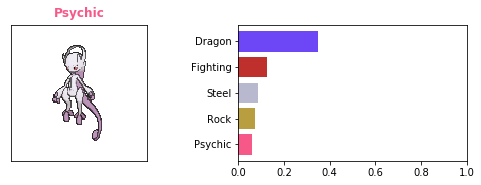

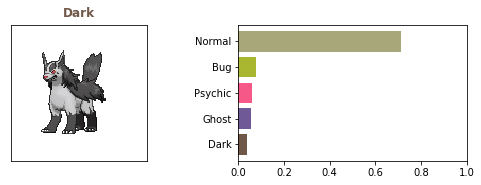

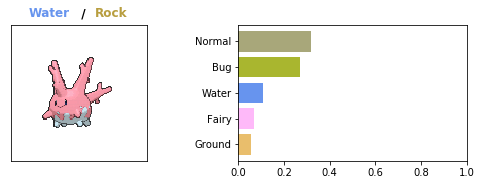

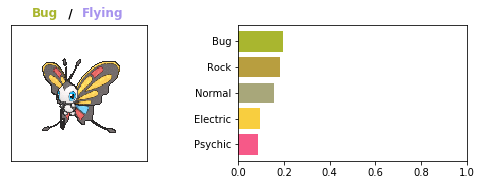

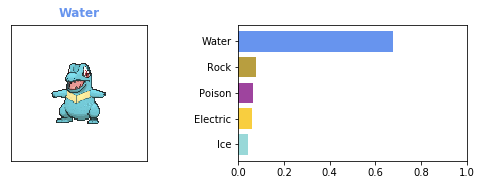

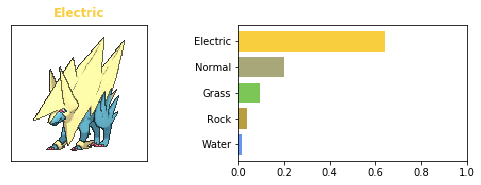

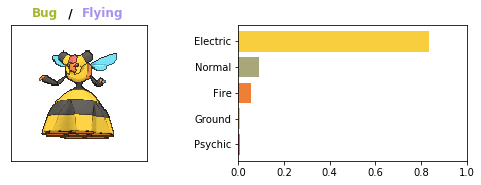

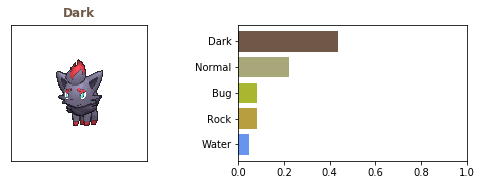

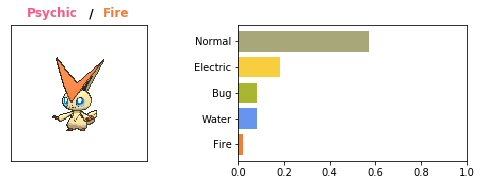

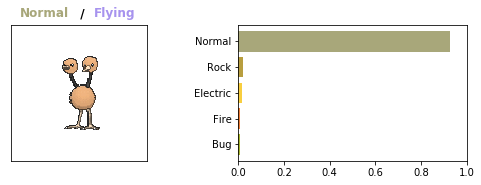

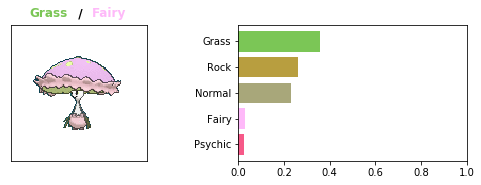

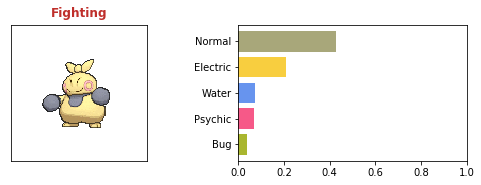

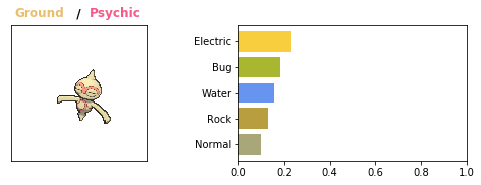

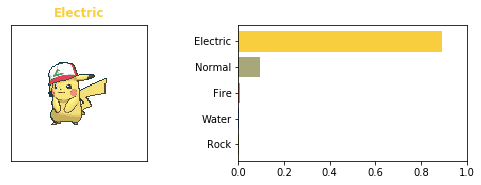

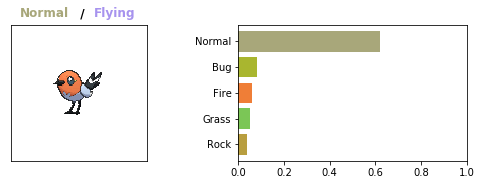

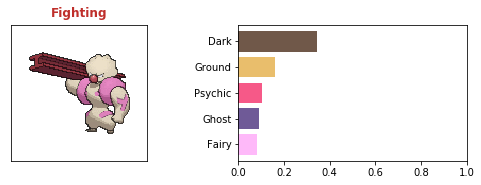

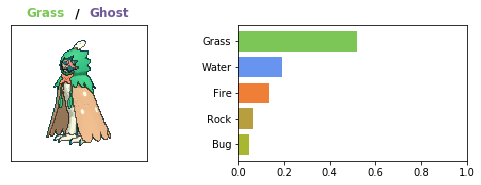

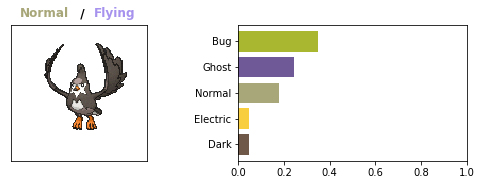

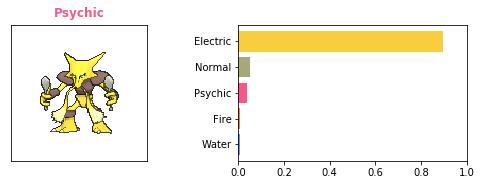

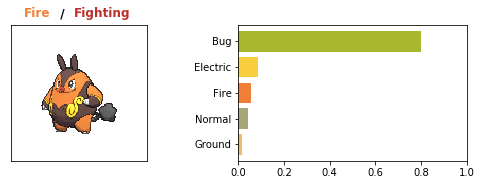

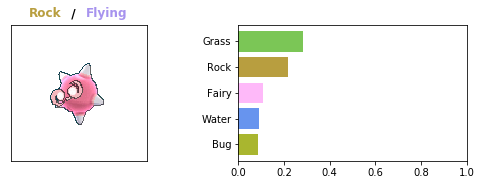

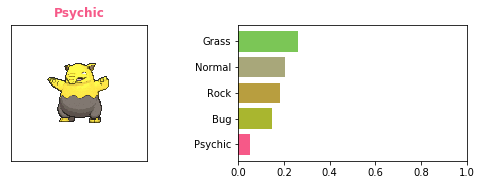

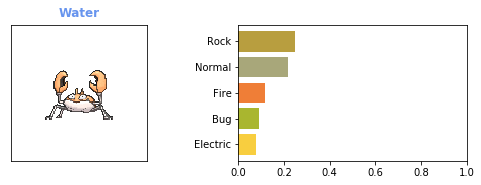

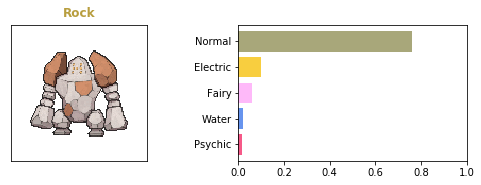

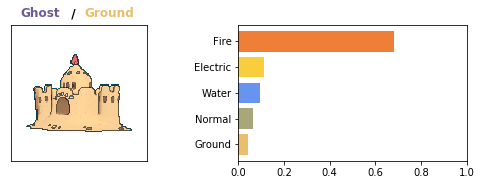

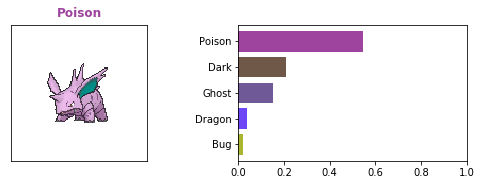

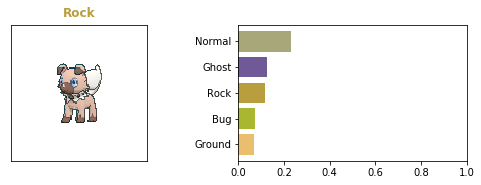

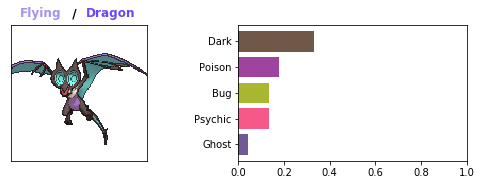

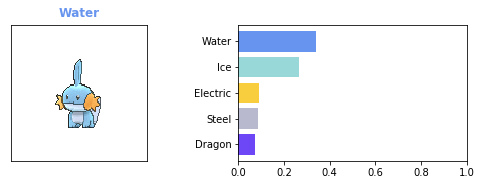

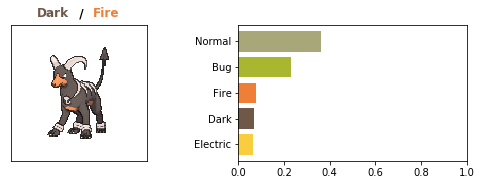

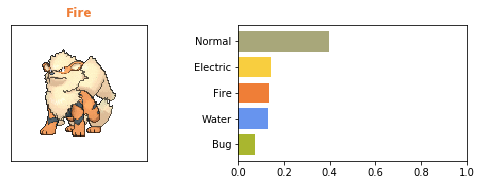

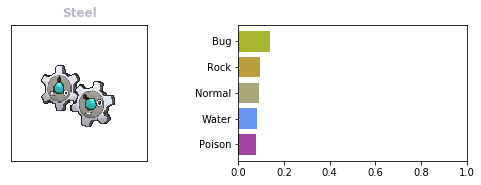

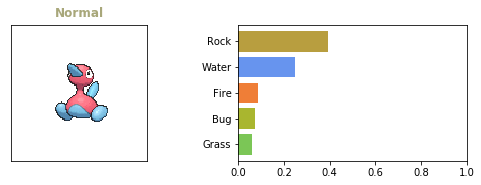

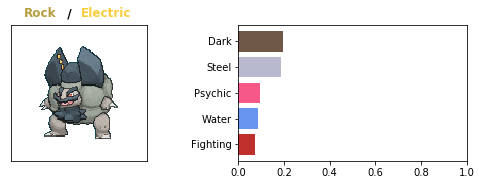

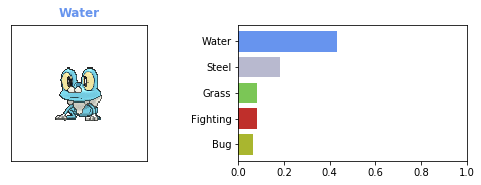

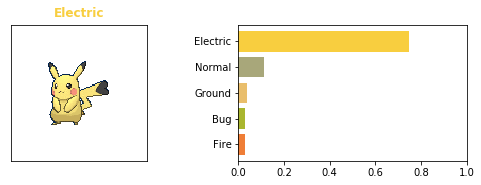

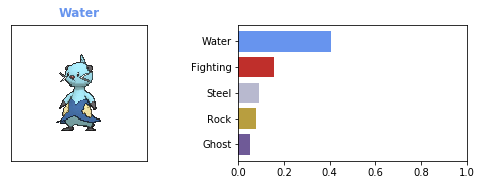

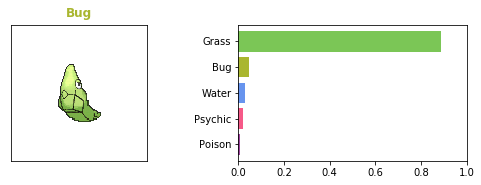

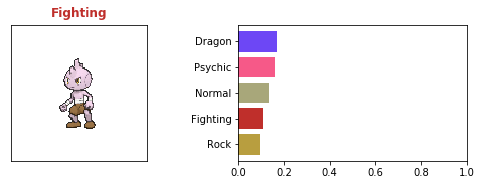

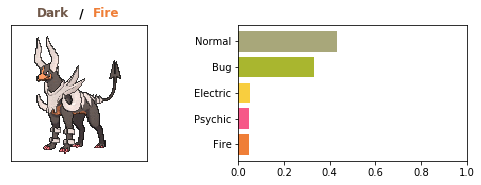

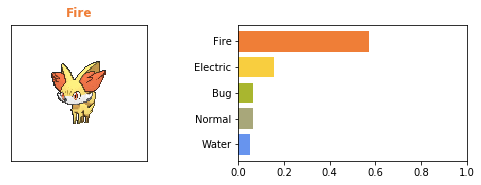

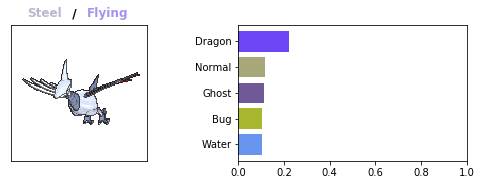

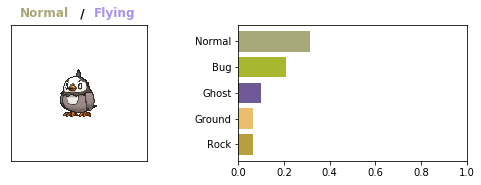

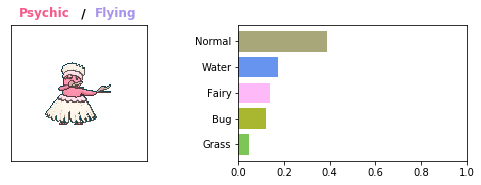

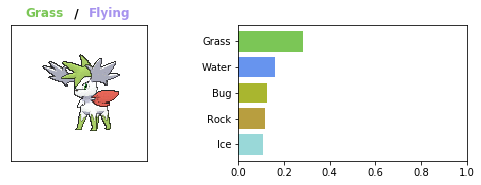

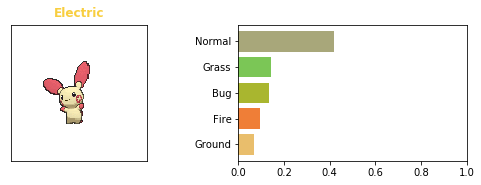

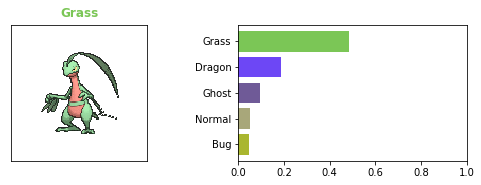

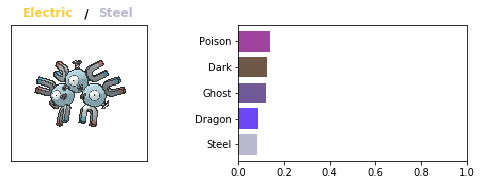

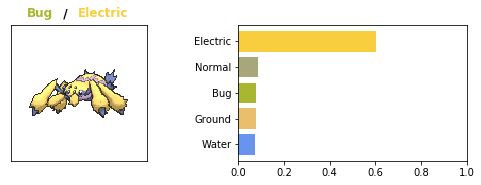

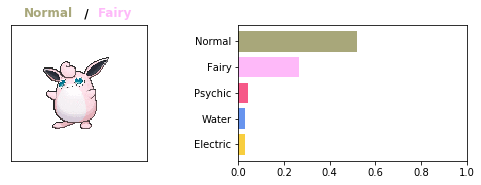

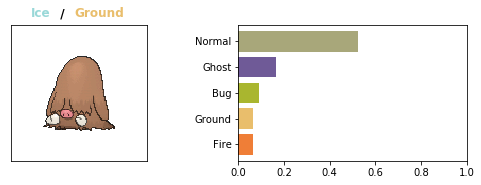

In [157]:
start = 0  # start index
num = 200    # number of images to display
step = 10  # number of frames / pokemon animation

print("Test predictions")
pp.plotPredictions(x_test_i[start*step:(start+num)*step:step],
                   y_test_m[start*step:(start+num)*step:step],
                   metrics_test["avg_scores"][start:start+num:1], k=5, y2=y_test_2[start*step:(start+num)*step:step])

In [168]:
drops = []
regs = []
histories = []

In [182]:
from keras.callbacks import EarlyStopping

# Test levels of regularization
for i in range(50):
    print()
    print("> Iteration", i+1)
    r = np.random.uniform(-5.5,-0.5)
    d = np.random.uniform(np.log10(0.1),np.log10(0.9))
    reg = 10**r
    drop = 1-10**d
    
    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=4, \
                              verbose=1, mode='auto')
    callbacks_list = [earlystop]


    model = getInitialModel(False, reg=reg, drop=drop, downsample=2, kernel=3)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    history = model.fit_generator(
        data_aug.flow(x_train_d, pmu.oneHot(y_train_d, 18), batch_size=64),
        epochs=10,
        verbose=1,
        validation_data=(x_val_d, pmu.oneHot(y_val_d, 18)),
        callbacks=callbacks_list,
    )
    drops.append(drop)
    regs.append(reg)
    histories.append(history.history)


> Iteration 1
Model params: drop = 0.7890368260053646 , reg = 0.008197642966141479
Epoch 1/10
47/47 [==============================] - 13s 283ms/step - loss: 3.7128 - acc: 0.0965 - val_loss: 3.2639 - val_acc: 0.1258
Epoch 2/10
47/47 [==============================] - 11s 236ms/step - loss: 3.1362 - acc: 0.1154 - val_loss: 3.0215 - val_acc: 0.1523
Epoch 3/10
47/47 [==============================] - 11s 238ms/step - loss: 2.9568 - acc: 0.1437 - val_loss: 2.8943 - val_acc: 0.1550
Epoch 4/10
47/47 [==============================] - 11s 238ms/step - loss: 2.8771 - acc: 0.1497 - val_loss: 2.8361 - val_acc: 0.1695
Epoch 5/10
47/47 [==============================] - 11s 237ms/step - loss: 2.8073 - acc: 0.1561 - val_loss: 2.8345 - val_acc: 0.1801
Epoch 6/10
47/47 [==============================] - 11s 239ms/step - loss: 2.7883 - acc: 0.1651 - val_loss: 2.8027 - val_acc: 0.1762
Epoch 7/10
47/47 [==============================] - 11s 238ms/step - loss: 2.7490 - acc: 0.1644 - val_loss: 2.7999 - v

47/47 [==============================] - 11s 234ms/step - loss: 2.9632 - acc: 0.1381 - val_loss: 2.9368 - val_acc: 0.1258
Epoch 00005: early stopping

> Iteration 9
Model params: drop = 0.8549764095897938 , reg = 0.0001827705351176599
Epoch 1/10
47/47 [==============================] - 14s 302ms/step - loss: 2.9227 - acc: 0.0965 - val_loss: 2.8815 - val_acc: 0.1430
Epoch 2/10
47/47 [==============================] - 11s 235ms/step - loss: 2.8629 - acc: 0.1161 - val_loss: 2.8524 - val_acc: 0.1550
Epoch 3/10
47/47 [==============================] - 11s 236ms/step - loss: 2.8225 - acc: 0.1198 - val_loss: 2.8177 - val_acc: 0.1298
Epoch 4/10
47/47 [==============================] - 11s 241ms/step - loss: 2.7914 - acc: 0.1418 - val_loss: 2.7743 - val_acc: 0.1722
Epoch 5/10
47/47 [==============================] - 11s 238ms/step - loss: 2.7570 - acc: 0.1404 - val_loss: 2.7751 - val_acc: 0.1616
Epoch 6/10
47/47 [==============================] - 11s 239ms/step - loss: 2.7331 - acc: 0.1507 - va

47/47 [==============================] - 15s 323ms/step - loss: 3.1031 - acc: 0.0992 - val_loss: 2.9712 - val_acc: 0.1391
Epoch 2/10
47/47 [==============================] - 11s 242ms/step - loss: 2.9046 - acc: 0.1375 - val_loss: 2.8282 - val_acc: 0.1377
Epoch 3/10
47/47 [==============================] - 11s 241ms/step - loss: 2.8066 - acc: 0.1618 - val_loss: 2.7952 - val_acc: 0.1709
Epoch 4/10
47/47 [==============================] - 11s 241ms/step - loss: 2.7517 - acc: 0.1681 - val_loss: 2.7685 - val_acc: 0.1881
Epoch 5/10
47/47 [==============================] - 11s 240ms/step - loss: 2.7122 - acc: 0.1781 - val_loss: 2.7574 - val_acc: 0.1894
Epoch 6/10
47/47 [==============================] - 11s 243ms/step - loss: 2.6825 - acc: 0.1977 - val_loss: 2.7215 - val_acc: 0.1722
Epoch 7/10
47/47 [==============================] - 11s 242ms/step - loss: 2.6515 - acc: 0.1950 - val_loss: 2.7079 - val_acc: 0.1828
Epoch 8/10
47/47 [==============================] - 12s 247ms/step - loss: 2.617

47/47 [==============================] - 13s 280ms/step - loss: 2.9212 - acc: 0.1225 - val_loss: 2.8637 - val_acc: 0.1404
Epoch 3/10
47/47 [==============================] - 13s 284ms/step - loss: 2.8554 - acc: 0.1461 - val_loss: 2.8403 - val_acc: 0.1258
Epoch 4/10
47/47 [==============================] - 13s 282ms/step - loss: 2.8061 - acc: 0.1465 - val_loss: 2.7958 - val_acc: 0.1404
Epoch 5/10
47/47 [==============================] - 13s 281ms/step - loss: 2.7485 - acc: 0.1687 - val_loss: 2.7636 - val_acc: 0.1868
Epoch 6/10
47/47 [==============================] - 13s 280ms/step - loss: 2.7446 - acc: 0.1607 - val_loss: 2.7672 - val_acc: 0.2093
Epoch 7/10
47/47 [==============================] - 13s 273ms/step - loss: 2.7071 - acc: 0.1647 - val_loss: 2.7455 - val_acc: 0.2106
Epoch 8/10
47/47 [==============================] - 13s 278ms/step - loss: 2.7000 - acc: 0.1800 - val_loss: 2.7465 - val_acc: 0.2106
Epoch 9/10
47/47 [==============================] - 13s 277ms/step - loss: 2.697

KeyboardInterrupt: 

IndexError: tuple index out of range

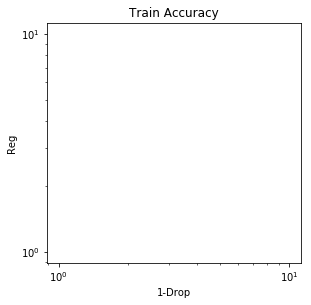

In [183]:
fig = plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(3,2)

for i in range(2):
    t = None
    accs = None
    losses = None
    if i == 0:
        t = "Train"
        accs = np.array([histories[i]['acc'] for i in range(len(histories))])
        losses = np.array([histories[i]['loss'] for i in range(len(histories))])
    else:
        t = "Validation"
        accs = np.array([histories[i]['val_acc'] for i in range(len(histories))])
        losses = np.array([histories[i]['val_loss'] for i in range(len(histories))])
                
    ax = plt.subplot(gs[i])
    ax.set_title(t + " Accuracy")
    ax.set_xlabel("1-Drop")
    ax.set_xscale('log')
    ax.set_ylabel("Reg")
    ax.set_yscale('log')
    colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
    c = [colors[i%len(colors)] for i in range(accs.shape[0])]
    nepochs = accs.shape[1]
    ax.scatter(1-np.array(drops), np.array(regs), s=(np.max(accs, axis=1)-0.1)*1e3, c=c)
    
    ax2 = plt.subplot(gs[i+2])
    ax2.set_title(t + " Accuracies")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(accs.T)
    
    ax3 = plt.subplot(gs[i+4])
    ax3.set_title(t + " Losses")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Loss")
    ax3.plot(losses.T)

plt.show()

In [167]:
save1 = (drops, regs, histories)